# Walmart Sales Forecast
* **BUSI 650 Summer 2022**
* **Inventory Shift Classification Model**
* **Group Project Members**: *Aryan, Xu, Zexian, Christopher*


##### **Objective** 

> Using the static features of a store and department with dynamic regional conditions such as temperature, consumer price index, fuel price and unemployment rate, determine if a department of a given store for a given week should be "downsized" BEFORE the store opens for that given week.

### ***Import packages and define functions.***

In [ ]:
# PACKAGES

# google colab file management
from google.colab import drive
import copy

# Library to suppress warnings or deprecation notes
import warnings

# To perform statistical analysis
from itertools import combinations
from scipy.stats import ttest_ind
import scipy.stats as stats
import statsmodels.api as sm
from statsmodels.tools.tools import add_constant
from math import log2, sqrt
import datetime

# Libraries to help with reading and manipulating data
import pandas as pd
import numpy as np

# libaries to help with data visualization
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from tqdm.notebook import tqdm

# To build models
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, VotingClassifier, BaggingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree

# Library to split data
from sklearn.model_selection import train_test_split

# for plotting calibration curve using true and predicted labels.
from sklearn.calibration import CalibrationDisplay

# To tune different models
from sklearn.model_selection import cross_val_score, GridSearchCV, RandomizedSearchCV, RepeatedStratifiedKFold

# To get diferent metric scores
from sklearn.metrics import (
    mean_absolute_error, mean_squared_error, r2_score, accuracy_score, confusion_matrix, 
    ConfusionMatrixDisplay, roc_curve, RocCurveDisplay, precision_recall_curve, roc_auc_score,
    PrecisionRecallDisplay, average_precision_score, auc, f1_score, recall_score, precision_score,
    plot_confusion_matrix, make_scorer, 
)

# matplotlib graphs will be included in notebook, next to the code
%matplotlib inline 

# format for seaborn plots
sns.set(color_codes=True)
sns.set(style="darkgrid")

# Removes the limit for the number of displayed columns
pd.set_option("display.max_columns", None)

# Sets the limit for the number of displayed rows
pd.set_option("display.max_rows", 200)

# ignore warnings
warnings.filterwarnings("ignore")

In [ ]:
# FUNCTIONS

# function to plot stacked bar chart.
def stacked_barplot(data, predictor, target):
    """
    Print the category counts and plot a stacked bar chart

    data: dataframe
    predictor: independent variable
    target: target variable
    """
    count = data[predictor].nunique()
    sorter = data[target].value_counts().index[-1]
    #tab1 = pd.crosstab(data[predictor], data[target], margins=True).sort_values(by=sorter, ascending=False)
    #print(tab1)
    #print("-" * 120)
    tab = pd.crosstab(data[predictor], data[target], normalize="index").sort_values(
        by=sorter, ascending=False
    )
    tab.plot(kind="bar", stacked=True, figsize=(count + 5, 6))
    plt.legend(
        loc="lower left",
        frameon=False,
    )
    plt.legend(loc="upper left", bbox_to_anchor=(1, 1))
    plt.show()

# function to create box plot and histplot on same axis
def HistBoxPlot(dataframe, feature, hue = None, cum = False, bins = 'auto'):
    f2, (ax_box2, ax_hist2) = plt.subplots(nrows = 2, # Number of rows of the subplot grid= 2
                                           sharex = True, # x-axis will be shared among all subplots
                                           gridspec_kw = {"height_ratios": (.25, .75)}, 
                                           figsize = (9,7)) 
                                          
    sns.boxplot(feature, ax=ax_box2, showmeans=True, color='yellow'); # A star will indicate the mean value of the column
    sns.histplot(data=dataframe, x=feature, kde=True, hue=hue, bins=bins, cumulative = cum, ax=ax_hist2); # For histogram
    ax_hist2.axvline(np.mean(feature), color='green', linestyle='-'); # Add mean to the histogram
    ax_hist2.axvline(np.median(feature), color='black', linestyle='-'); # Add median to the histogram

# function to create labeled barplots
def labeled_barplot(data, feature, perc=False, n=None):
    """
    Barplot with percentage at the top

    data: dataframe
    feature: dataframe column
    perc: whether to display percentages instead of count (default is False)
    n: displays the top n category levels (default is None, i.e., display all levels)
    """

    total = len(data[feature])  # length of the column
    count = data[feature].nunique()
    if n is None:
        plt.figure(figsize=(count + 2, 6))
    else:
        plt.figure(figsize=(n + 2, 6))

    plt.xticks(rotation=90, fontsize=15)
    ax = sns.countplot(
        data=data,
        x=feature,
        palette="Paired",
        order=data[feature].value_counts().index[:n].sort_values(),
    )

    for p in ax.patches:
        if perc == True:
            label = "{:.1f}%".format(
                100 * p.get_height() / total
            )  # percentage of each class of the category
        else:
            label = p.get_height()  # count of each level of the category

        x = p.get_x() + p.get_width() / 2  # width of the plot
        y = p.get_height()  # height of the plot

        ax.annotate(
            label,
            (x, y),
            ha="center",
            va="center",
            size=12,
            xytext=(0, 5),
            textcoords="offset points",
        )  # annotate the percentage

    plt.show()  # show the plot

# defining a function to compute different metrics to check performance of a classification model built using sklearn
def model_performance_classification(model, predictors, target):

    pred = model.predict(predictors)

    acc = accuracy_score(target, pred)  # to compute Accuracy
    recall = recall_score(target, pred)  # to compute Recall
    precision = precision_score(target, pred)  # to compute Precision
    f1 = f1_score(target, pred)  # to compute F1-score

    # creating a dataframe of metrics
    df_perf = pd.DataFrame(
        {
            "Accuracy": acc,
            "Recall": recall,
            "Precision": precision,
            "F1": f1,
        },
        index=[0],
    )

    return df_perf

def make_confusion_matrix(model, predictors, target):

    y_pred = model.predict(predictors)
    cm = confusion_matrix(target, y_pred)
    group_names = ["True Neg", "False Pos", "False Neg", "True Pos"]
    group_counts = ["{0:0.0f}".format(value) for value in cm.flatten()]
    group_percentages = ["{0:.2%}".format(value) for value in cm.flatten() / np.sum(cm)]
    labels = [
        f"{v1}\n{v2}\n{v3}"
        for v1, v2, v3 in zip(group_names, group_counts, group_percentages)
    ]
    labels = np.asarray(labels).reshape(2, 2)
    sns.heatmap(cm, annot=labels, fmt="", cmap="Blues")

### ***Read the dataset into pandas dataframes.***

In [ ]:
# Authorization of GDrive
drive.mount('/content/drive/')

# Change working directory location to datasets
%cd /content/drive/MyDrive/Data_Science/BUSI_650_Business_Analytics_Decision_Making/Data_Sets

Mounted at /content/drive/
/content/drive/MyDrive/Data_Science/BUSI_650_Business_Analytics_Decision_Making/Data_Sets


In [ ]:
# view datasets in directory
%ls 

AOVData.csv                          Loan_Delinquent_Dataset.csv
assignment.csv                       movie.csv
Automobile.csv                       mtcars.csv
auto-mpg.csv                         NEP.csv
Beverage.csv                         OfficeSupplies.csv
bookseller.csv                       Pima_Indians.csv
boston.csv                           ratings.csv
debugging.csv                        sat_score.csv
diet.csv                             SATVerbal1.csv
doses.csv                            TitanInsurance.csv
Engineering_Colleges_Case_Study.csv  ToyotaCorolla.csv
FastFood1.csv                        TVRadio.csv
Florida.csv                          UniversalBank.csv
German_Credit.csv                    user.csv
honeyproduction1998-2016.csv         Walmart_Features_data_set.csv
InternetMobileTime.csv               Walmart_sales_data_set.csv
iris.csv                             Walmart_stores_data_set.csv
Loan_Customers.csv                   working_adults.csv


In [ ]:
# Load proper datasets
stores = pd.read_csv('Walmart_stores_data_set.csv')
sales = pd.read_csv('Walmart_sales_data_set.csv')
features = pd.read_csv('Walmart_Features_data_set.csv')

### ***EDA Part 1***

#### ***Table #1: Stores***

In [ ]:
# display data types in table
stores.dtypes

Store     int64
Type     object
Size      int64
dtype: object

In [ ]:
# provide stat summary of columns in table
stores.describe(include='all')

,Store,Type,Size
count,45.000000,45,45.000000
unique,NaN,3,NaN
top,NaN,A,NaN
freq,NaN,22,NaN
mean,23.000000,NaN,130287.600000
std,13.133926,NaN,63825.271991
min,1.000000,NaN,34875.000000
25%,12.000000,NaN,70713.000000
50%,23.000000,NaN,126512.000000
75%,34.000000,NaN,202307.000000


In [ ]:
# show number of null values in each column
stores.isnull().sum()

Store    0
Type     0
Size     0
dtype: int64

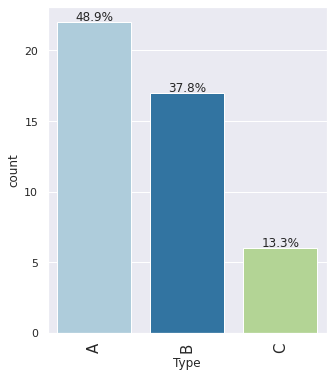

In [ ]:
labeled_barplot(stores, "Type", perc=True)

> **About 49% of the stores are considered a Type A store followed by Type B with 38% and Type C with 13%.**


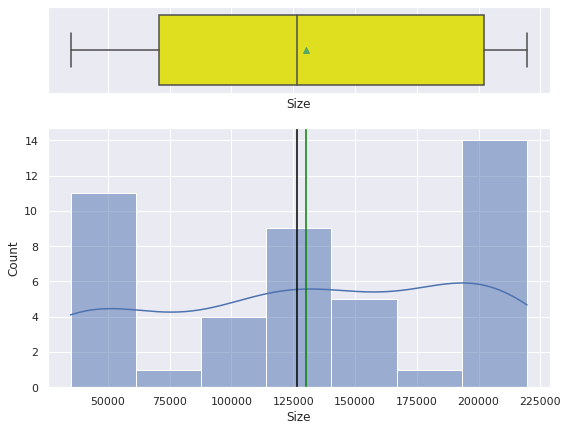

In [ ]:
HistBoxPlot(stores, stores.Size);

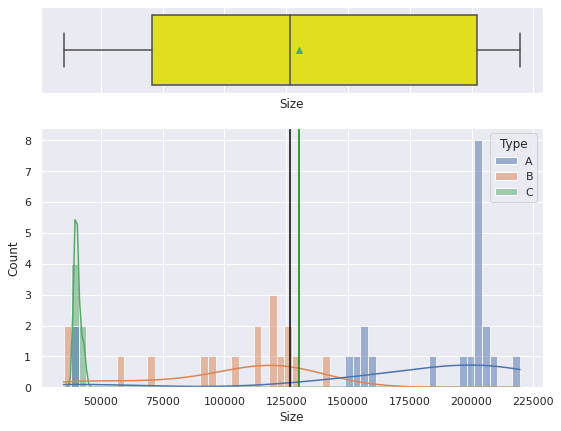

In [ ]:
HistBoxPlot(stores, stores.Size, stores.Type, bins=60);

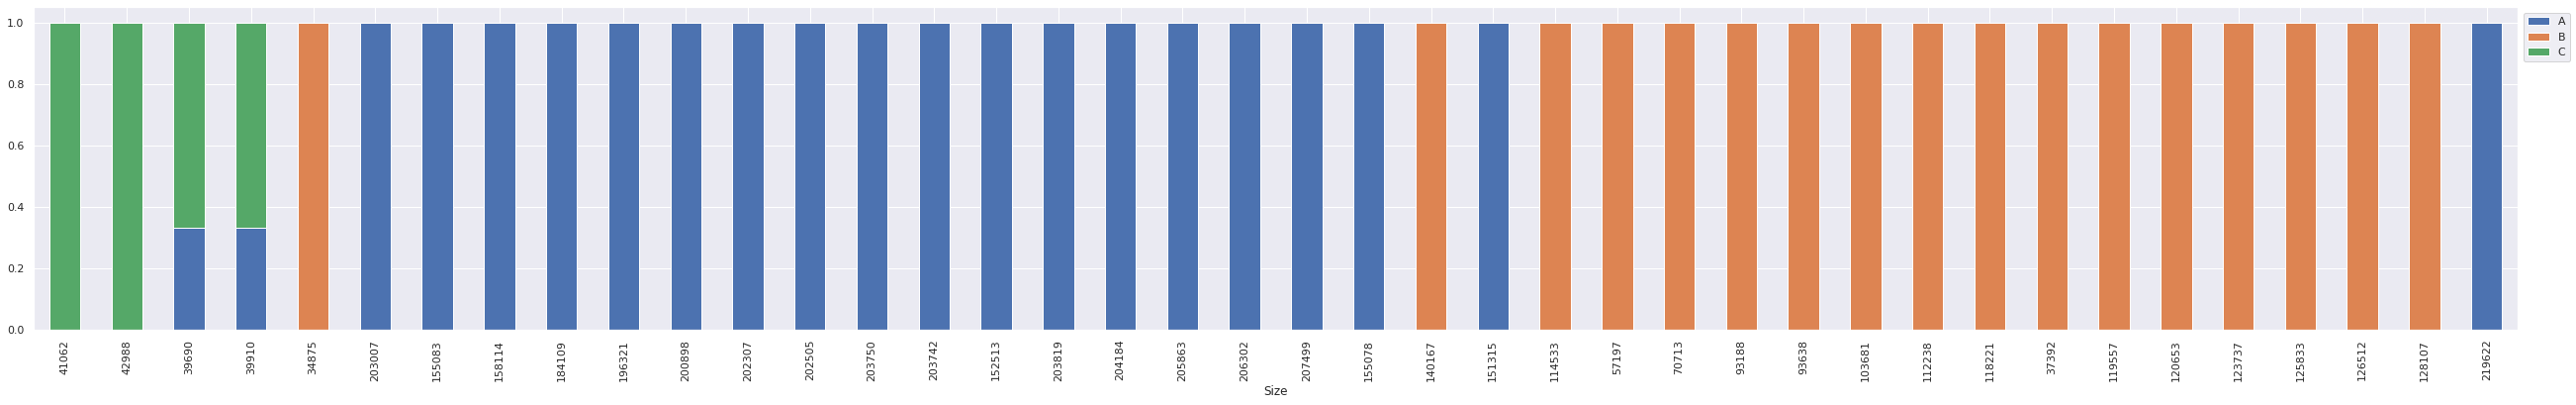

In [ ]:
stacked_barplot(stores, "Size", "Type")



> **Most of the Type A stores have sizes above the mean size for all stores. Type C stores are the smallest stores.**



#### ***Table #2: Sales***

In [ ]:
# display data types in table
sales.dtypes

Store             int64
Dept              int64
Date             object
Weekly_Sales    float64
IsHoliday          bool
dtype: object

In [ ]:
# provide stat summary of columns in table
sales.describe(include='all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
Store,421570.0,NaN,NaN,NaN,22.200546,12.785297,1.0,11.0,22.0,33.0,45.0
Dept,421570.0,NaN,NaN,NaN,44.260317,30.492054,1.0,18.0,37.0,74.0,99.0
Date,421570,143,23/12/2011,3027,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Weekly_Sales,421570.0,NaN,NaN,NaN,15981.258123,22711.183519,-4988.94,2079.65,7612.03,20205.8525,693099.36
IsHoliday,421570,2,False,391909,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
# show number of null values in each column
sales.isnull().sum()

Store           0
Dept            0
Date            0
Weekly_Sales    0
IsHoliday       0
dtype: int64

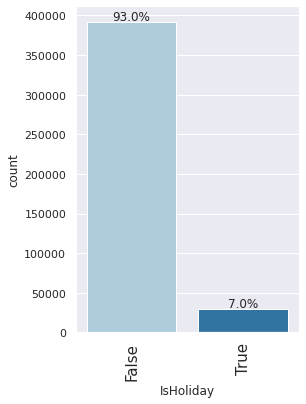

In [ ]:
labeled_barplot(sales, "IsHoliday", perc=True)



> **Only 7% of the reported sales occured during a holiday week**



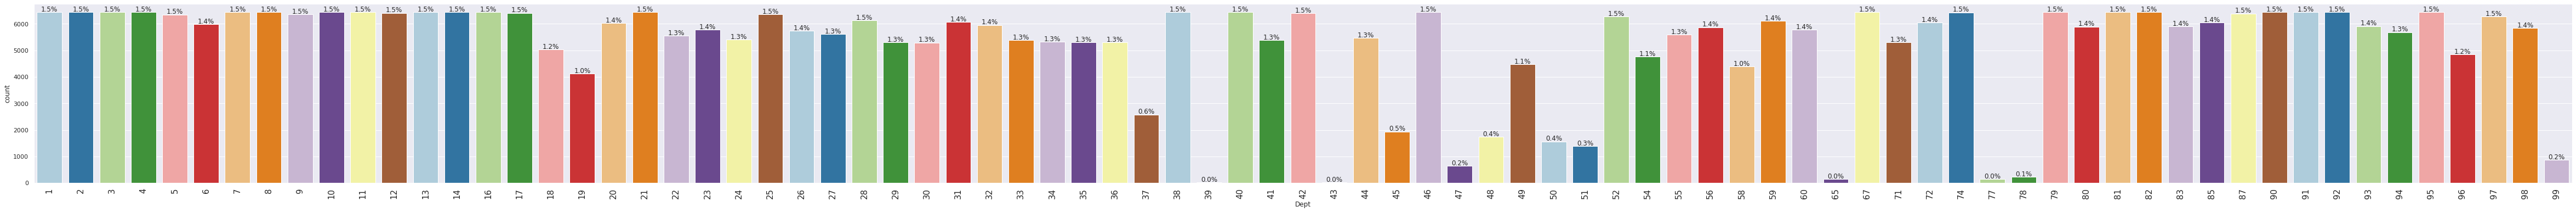

In [ ]:
labeled_barplot(sales, "Dept", perc=True)



> **There are stores that do not share the same department. Departments 39, 43, 47, 51, 65, 77, 78 and 99 are the least likely departments to be shared amoung all stores**



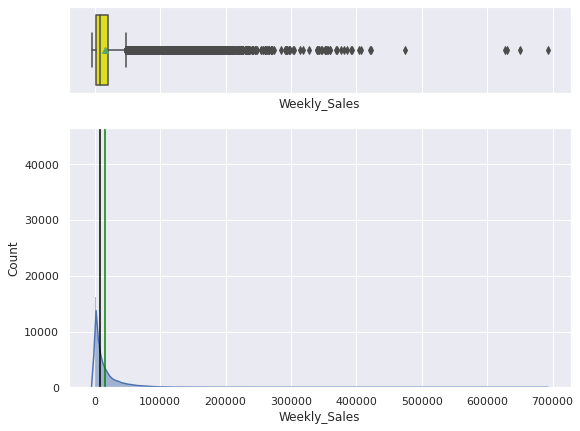

In [ ]:
HistBoxPlot(sales, sales.Weekly_Sales);

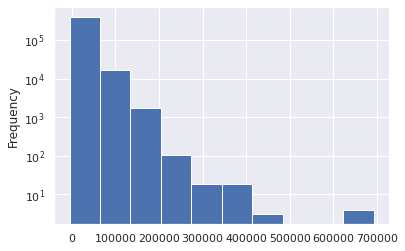

In [ ]:
sales.Weekly_Sales.plot(kind="hist", logy=True);



> **The number of sales reported exponentially decrease as the weekly sales figures increase. Most of the reported sales are on the lower end.**



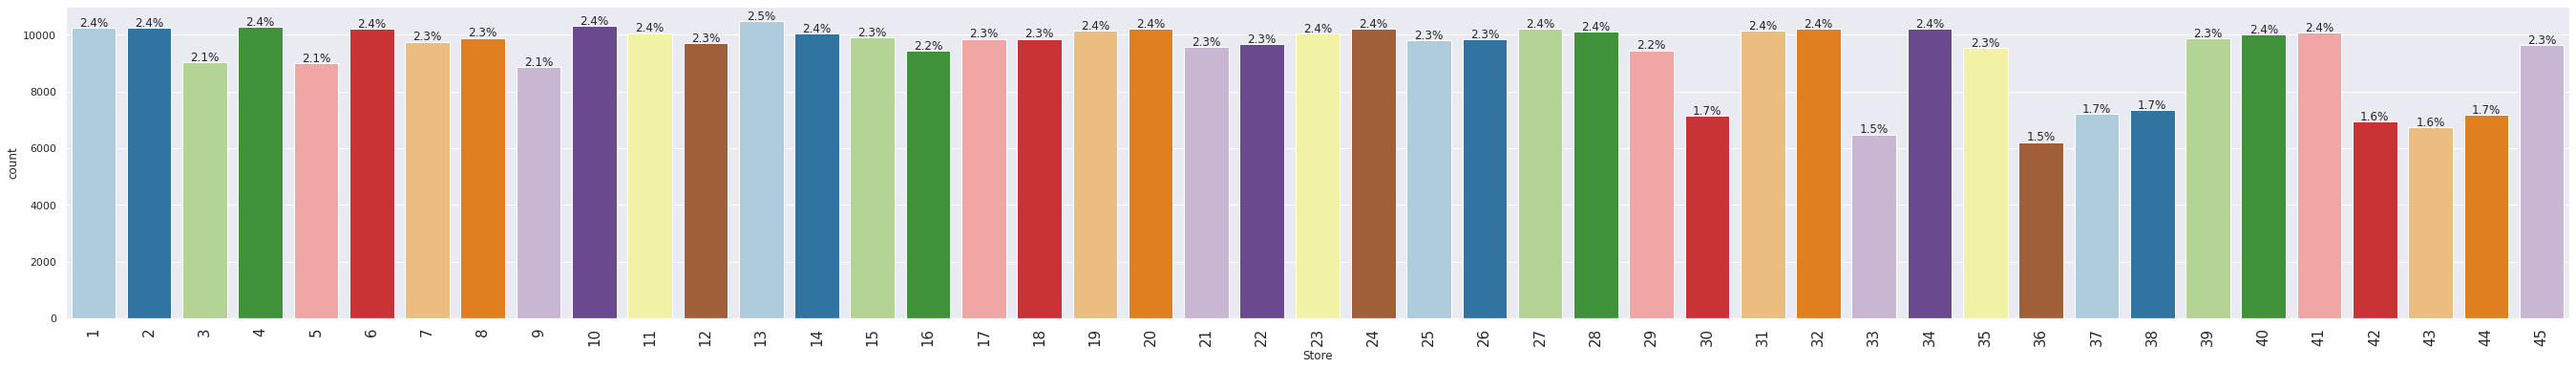

In [ ]:
labeled_barplot(sales, "Store", perc=True)



> **Most of the 45 stores have reported their sales. There are a few stores that have not reported all of their sales.**



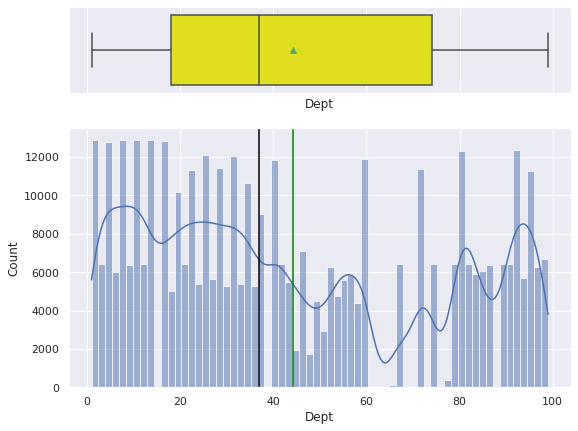

In [ ]:
HistBoxPlot(sales, sales.Dept);



> **There are departments that do not have many sales reports.**



#### ***Table #3: Features***

In [ ]:
# display data types in table
features.dtypes

Store             int64
Date             object
Temperature     float64
Fuel_Price      float64
MarkDown1       float64
MarkDown2       float64
MarkDown3       float64
MarkDown4       float64
MarkDown5       float64
CPI             float64
Unemployment    float64
IsHoliday          bool
dtype: object

In [ ]:
# provide stat summary of columns in table
features.describe(include='all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
Store,8190.0,NaN,NaN,NaN,23.0,12.987966,1.0,12.0,23.0,34.0,45.0
Date,8190,182,05/02/2010,45,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Temperature,8190.0,NaN,NaN,NaN,59.356198,18.678607,-7.29,45.9025,60.71,73.88,101.95
Fuel_Price,8190.0,NaN,NaN,NaN,3.405992,0.431337,2.472,3.041,3.513,3.743,4.468
MarkDown1,4032.0,NaN,NaN,NaN,7032.371786,9262.747448,-2781.45,1577.5325,4743.58,8923.31,103184.98
MarkDown2,2921.0,NaN,NaN,NaN,3384.176594,8793.583016,-265.76,68.88,364.57,2153.35,104519.54
MarkDown3,3613.0,NaN,NaN,NaN,1760.10018,11276.462208,-179.26,6.6,36.26,163.15,149483.31
MarkDown4,3464.0,NaN,NaN,NaN,3292.935886,6792.329861,0.22,304.6875,1176.425,3310.0075,67474.85
MarkDown5,4050.0,NaN,NaN,NaN,4132.216422,13086.690278,-185.17,1440.8275,2727.135,4832.555,771448.1
CPI,7605.0,NaN,NaN,NaN,172.460809,39.738346,126.064,132.364839,182.764003,213.932412,228.976456


In [ ]:
# show number of null values in each column
features.isnull().sum()

Store              0
Date               0
Temperature        0
Fuel_Price         0
MarkDown1       4158
MarkDown2       5269
MarkDown3       4577
MarkDown4       4726
MarkDown5       4140
CPI              585
Unemployment     585
IsHoliday          0
dtype: int64

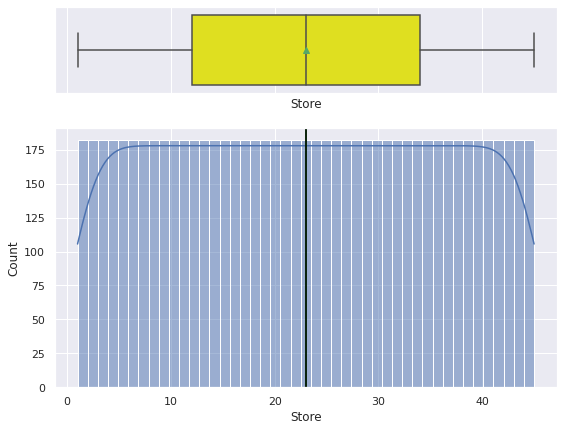

In [ ]:
HistBoxPlot(features, features.Store, bins = 45);

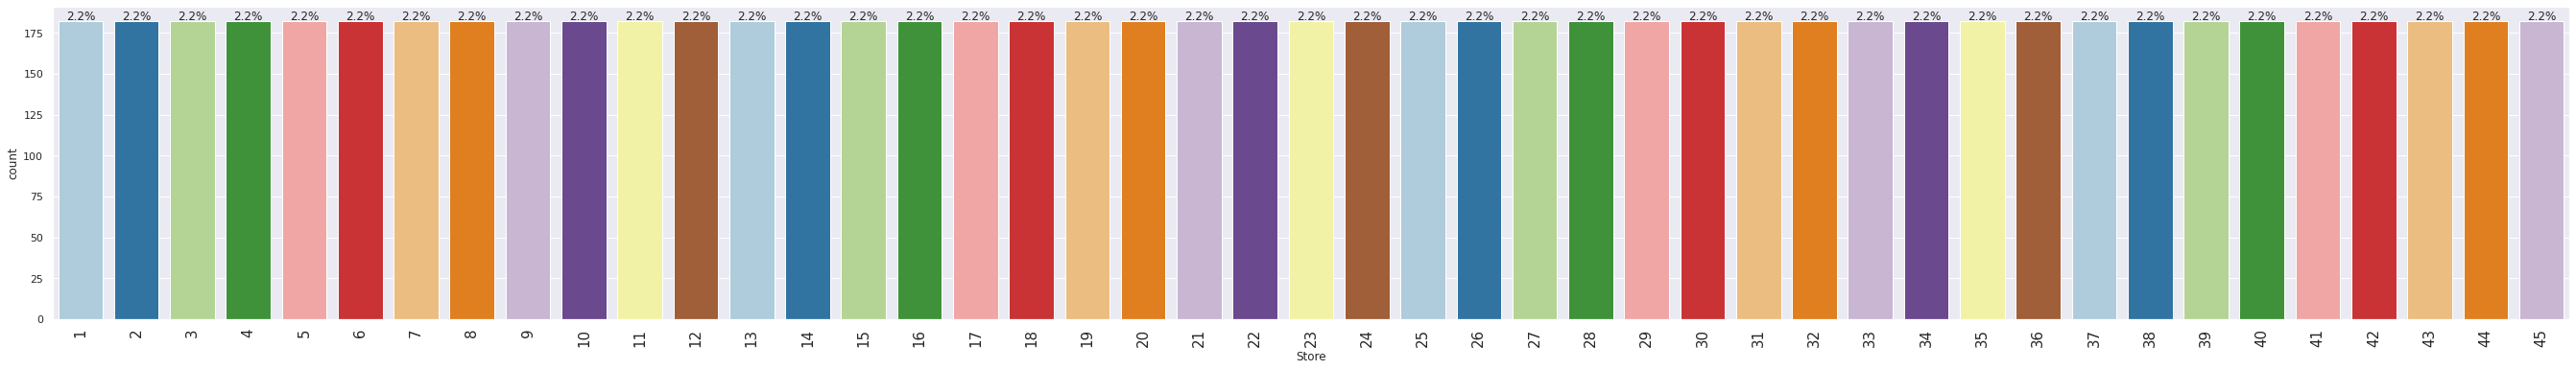

In [ ]:
labeled_barplot(features, "Store", perc=True)



> **All 45 stores have reported regional conditions throughout the years in this dataset.**



### ***Join Original Tables and Identify Quarter Segments***

In [ ]:
# Full Join stores and sales using 'Store' as primary key
df = pd.merge(stores, sales, on=['Store'])

# Full Join previous join and features using 'Store, Date and IsHoliday' as primary key
df = pd.merge(df, features, on=['Store', 'Date', 'IsHoliday'])

# Change to category variable
df.Store = df.Store.astype('category')
df.Dept = df.Dept.astype('category')
df.Type = df.Type.astype('category')
df.IsHoliday = df.IsHoliday.astype('category')

# Convert Date column to datetime variable - Date originally is in dd-mm-yyyy format
df.Date = pd.to_datetime(df.Date, dayfirst=True)

# Create new columns Quarter and Quarter_Info from column Date
df['Quarter'] = df['Date'].dt.quarter.astype('category')
df.Quarter.replace({1: 'Q1', 2: 'Q2', 3: 'Q3', 4: 'Q4'}, inplace=True)
df.Quarter = df.Quarter.astype('category')

df['Quarter_Info'] = df['Date'].dt.to_period('Q').astype(str).astype('category')

# Reformat column Date to only include date and remove times: format is now yyyy-mm-dd
df.Date = df.Date.dt.date

df.head()

,Store,Type,Size,Dept,Date,Weekly_Sales,IsHoliday,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Quarter,Quarter_Info
0,1,A,151315,1,2010-02-05,24924.50,False,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,Q1,2010Q1
1,1,A,151315,2,2010-02-05,50605.27,False,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,Q1,2010Q1
2,1,A,151315,3,2010-02-05,13740.12,False,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,Q1,2010Q1
3,1,A,151315,4,2010-02-05,39954.04,False,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,Q1,2010Q1
4,1,A,151315,5,2010-02-05,32229.38,False,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,Q1,2010Q1




> **After merging the three tables using their primary keys, a newly form dataset was the result with all variables from the three tables. Using the Date Column, new variables Quarter and Quarter_info was created to describe the quarter the sales report was submitted.**



In [ ]:
# show number of null values in each column
df.isnull().sum()

Store                0
Type                 0
Size                 0
Dept                 0
Date                 0
Weekly_Sales         0
IsHoliday            0
Temperature          0
Fuel_Price           0
MarkDown1       270889
MarkDown2       310322
MarkDown3       284479
MarkDown4       286603
MarkDown5       270138
CPI                  0
Unemployment         0
Quarter              0
Quarter_Info         0
dtype: int64

In [ ]:
df.shape

(421570, 18)

In [ ]:
df.drop_duplicates(inplace=True)
df.shape

(421570, 18)

In [ ]:
df.dtypes

Store           category
Type            category
Size               int64
Dept            category
Date              object
Weekly_Sales     float64
IsHoliday       category
Temperature      float64
Fuel_Price       float64
MarkDown1        float64
MarkDown2        float64
MarkDown3        float64
MarkDown4        float64
MarkDown5        float64
CPI              float64
Unemployment     float64
Quarter         category
Quarter_Info    category
dtype: object



> **Although there are no duplicated rows or records, the Markdown columns have null values. These columns refer to how much an item within a store or department either increased or decreases in value due to a promotion.**



### ***EDA Part 2***

#### ***Univariate Analysis***

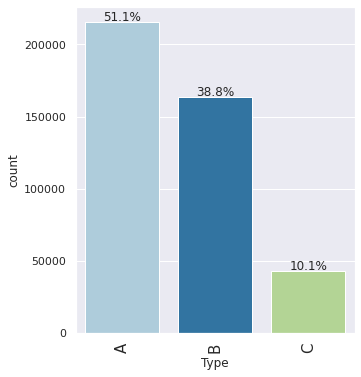

In [ ]:
labeled_barplot(df, "Type", perc=True)



> **The distribution of store types changed slightly due to more Type A and Type B stores reporting sales compared to Type C stores.**



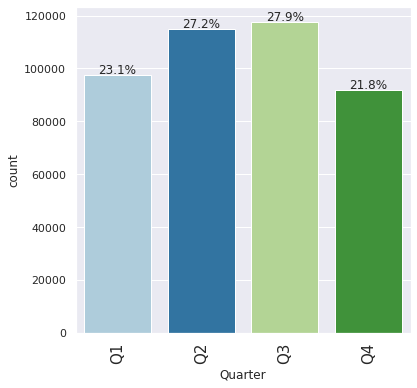

In [ ]:
labeled_barplot(df, "Quarter", perc=True)



> **There are more sales reports filed during the Quarter 2 and Quarter 3 months.**



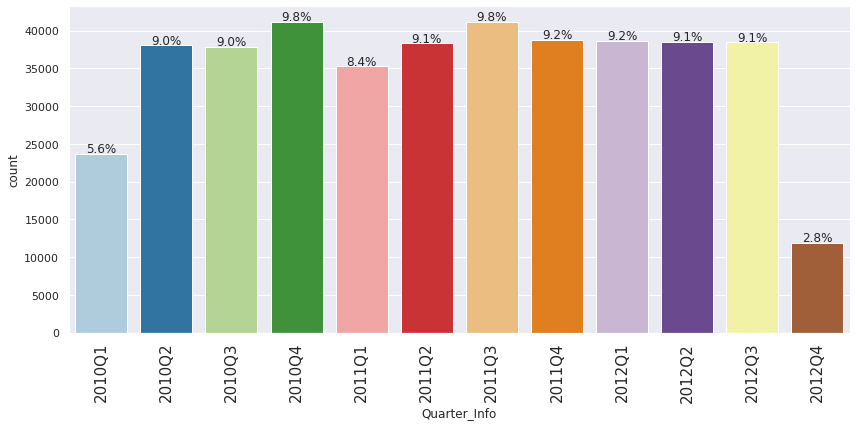

In [ ]:
labeled_barplot(df, "Quarter_Info", perc=True)



> **Since the dataset begins in February, the low number of records during the Q1 and Q4 months may be reflective to whent he dataset was reported.**



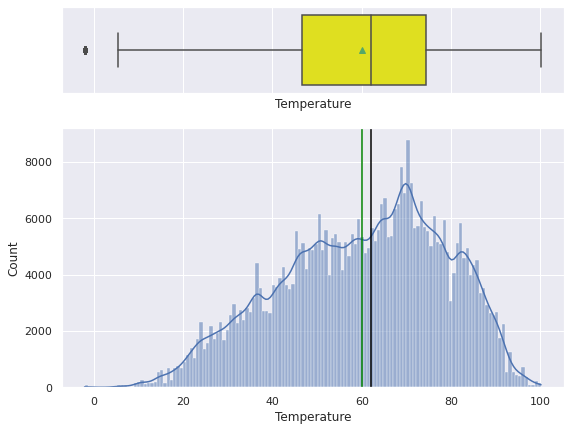

In [ ]:
HistBoxPlot(df, df.Temperature);



> **Temperature distribution amoung the reported records appears to be slightly skewed to the left.**



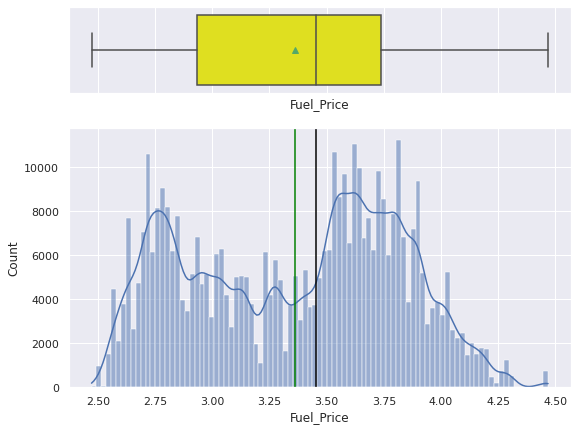

In [ ]:
HistBoxPlot(df, df.Fuel_Price);




> **The Fuel Prices has a mean around $3.40**



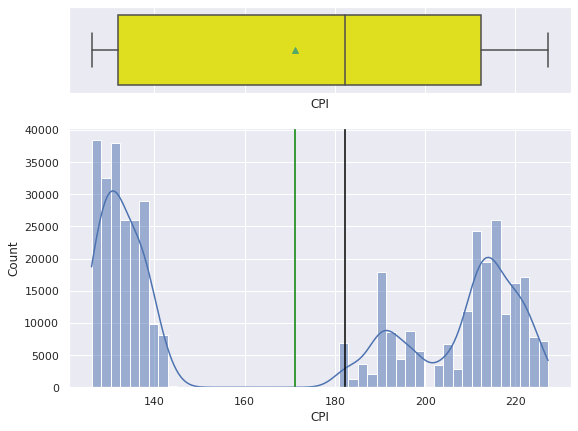

In [ ]:
HistBoxPlot(df, df.CPI);



> **The CPI is dramatically split with peaks around 130 and 210. The mean hovers around 170**



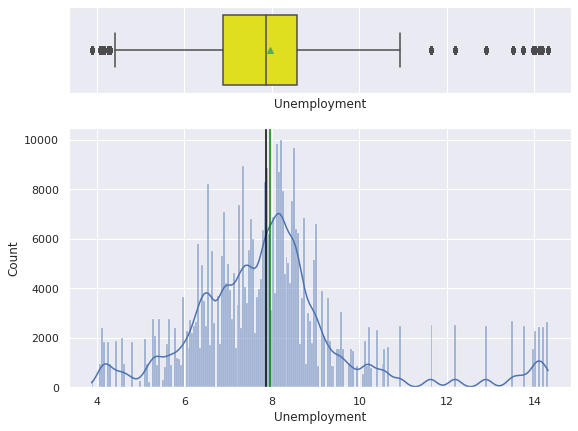

In [ ]:
HistBoxPlot(df, df.Unemployment);

>·**Unemployment rate distribution appears to be skewed to the right but the mean hovers around high 7%**

In [ ]:
df = df.drop(columns=['MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4', 'MarkDown5'])



> **Markdown columns were removed since we were not interested in how markdown prices affected sales**



In [ ]:
# show number of null values in each column
df.isnull().sum()

Store           0
Type            0
Size            0
Dept            0
Date            0
Weekly_Sales    0
IsHoliday       0
Temperature     0
Fuel_Price      0
CPI             0
Unemployment    0
Quarter         0
Quarter_Info    0
dtype: int64

In [ ]:
df.head()

,Store,Type,Size,Dept,Date,Weekly_Sales,IsHoliday,Temperature,Fuel_Price,CPI,Unemployment,Quarter,Quarter_Info
0,1,A,151315,1,2010-02-05,24924.50,False,42.31,2.572,211.096358,8.106,Q1,2010Q1
1,1,A,151315,2,2010-02-05,50605.27,False,42.31,2.572,211.096358,8.106,Q1,2010Q1
2,1,A,151315,3,2010-02-05,13740.12,False,42.31,2.572,211.096358,8.106,Q1,2010Q1
3,1,A,151315,4,2010-02-05,39954.04,False,42.31,2.572,211.096358,8.106,Q1,2010Q1
4,1,A,151315,5,2010-02-05,32229.38,False,42.31,2.572,211.096358,8.106,Q1,2010Q1




> **After removal of the Markdown Columns, there are no columns or rows with null values.**



### ***Data Manipulation and Calculation***

In [ ]:
df.columns

Index(['Store', 'Type', 'Size', 'Dept', 'Date', 'Weekly_Sales', 'IsHoliday',
       'Temperature', 'Fuel_Price', 'CPI', 'Unemployment', 'Quarter',
       'Quarter_Info'],
      dtype='object')

In [ ]:
# group by store and date then take sum of store sales based on the date
df_store_weekly_sales_sum = df.groupby(['Store','Date'])['Weekly_Sales'].sum().reset_index()
df_store_weekly_sales_sum.rename(columns={"Weekly_Sales": "Store_Weekly_Sales"}, inplace=True)
df_store_weekly_sales_sum

,Store,Date,Store_Weekly_Sales
0,1,2010-02-05,1643690.90
1,1,2010-02-12,1641957.44
2,1,2010-02-19,1611968.17
3,1,2010-02-26,1409727.59
4,1,2010-03-05,1554806.68
...,...,...,...
6430,45,2012-09-28,713173.95
6431,45,2012-10-05,733455.07
6432,45,2012-10-12,734464.36
6433,45,2012-10-19,718125.53




> **New dataframe contains the sum of weekly sales of a store for a given date.**



#### ***Join New Data to Table***

In [ ]:
# Full Join using 'Store' and 'Date' as primary key
df = pd.merge(df, df_store_weekly_sales_sum, on=['Store','Date'])
df.rename(columns={"Weekly_Sales": "Dept_Weekly_Sales"}, inplace=True)
df

,Store,Type,Size,Dept,Date,Dept_Weekly_Sales,IsHoliday,Temperature,Fuel_Price,CPI,Unemployment,Quarter,Quarter_Info,Store_Weekly_Sales
0,1,A,151315,1,2010-02-05,24924.50,False,42.31,2.572,211.096358,8.106,Q1,2010Q1,1643690.90
1,1,A,151315,2,2010-02-05,50605.27,False,42.31,2.572,211.096358,8.106,Q1,2010Q1,1643690.90
2,1,A,151315,3,2010-02-05,13740.12,False,42.31,2.572,211.096358,8.106,Q1,2010Q1,1643690.90
3,1,A,151315,4,2010-02-05,39954.04,False,42.31,2.572,211.096358,8.106,Q1,2010Q1,1643690.90
4,1,A,151315,5,2010-02-05,32229.38,False,42.31,2.572,211.096358,8.106,Q1,2010Q1,1643690.90
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
421565,45,B,118221,93,2012-10-26,2487.80,False,58.85,3.882,192.308899,8.667,Q4,2012Q4,760281.43
421566,45,B,118221,94,2012-10-26,5203.31,False,58.85,3.882,192.308899,8.667,Q4,2012Q4,760281.43
421567,45,B,118221,95,2012-10-26,56017.47,False,58.85,3.882,192.308899,8.667,Q4,2012Q4,760281.43
421568,45,B,118221,97,2012-10-26,6817.48,False,58.85,3.882,192.308899,8.667,Q4,2012Q4,760281.43




> **Store Weekly Sales based on the date is now merged with the original dataframe**



#### ***Remove Negative Sales Reports***

In [ ]:
df.drop(df[df.Dept_Weekly_Sales < 0].index, inplace=True)
df.drop(df[df.Store_Weekly_Sales < 0].index, inplace=True)
df.dropna(inplace=True)



> **All negative sales which implies the store lost revenue was removed from the dataset**



#### ***Create Class Label***

In [ ]:
# determine how much a department contributed to the overall sales in a store for a given date
df['Dept_Perc_Share_of_Store_Sales'] = (df.Dept_Weekly_Sales/df.Store_Weekly_Sales)*100
df

,Store,Type,Size,Dept,Date,Dept_Weekly_Sales,IsHoliday,Temperature,Fuel_Price,CPI,Unemployment,Quarter,Quarter_Info,Store_Weekly_Sales,Dept_Perc_Share_of_Store_Sales
0,1,A,151315,1,2010-02-05,24924.50,False,42.31,2.572,211.096358,8.106,Q1,2010Q1,1643690.90,1.516374
1,1,A,151315,2,2010-02-05,50605.27,False,42.31,2.572,211.096358,8.106,Q1,2010Q1,1643690.90,3.078758
2,1,A,151315,3,2010-02-05,13740.12,False,42.31,2.572,211.096358,8.106,Q1,2010Q1,1643690.90,0.835931
3,1,A,151315,4,2010-02-05,39954.04,False,42.31,2.572,211.096358,8.106,Q1,2010Q1,1643690.90,2.430751
4,1,A,151315,5,2010-02-05,32229.38,False,42.31,2.572,211.096358,8.106,Q1,2010Q1,1643690.90,1.960793
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
421565,45,B,118221,93,2012-10-26,2487.80,False,58.85,3.882,192.308899,8.667,Q4,2012Q4,760281.43,0.327221
421566,45,B,118221,94,2012-10-26,5203.31,False,58.85,3.882,192.308899,8.667,Q4,2012Q4,760281.43,0.684393
421567,45,B,118221,95,2012-10-26,56017.47,False,58.85,3.882,192.308899,8.667,Q4,2012Q4,760281.43,7.367991
421568,45,B,118221,97,2012-10-26,6817.48,False,58.85,3.882,192.308899,8.667,Q4,2012Q4,760281.43,0.896705


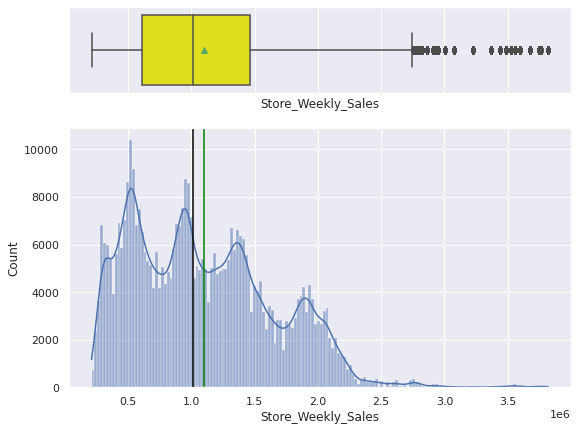

In [ ]:
HistBoxPlot(df, df.Store_Weekly_Sales);



> **The mean of the reported sales the stores is around 1.1 million dollars. Half of the reported sales were below this mean.**



In [ ]:
df.Dept_Perc_Share_of_Store_Sales.describe(include='all')

count    420285.000000
mean          1.531126
std           2.090368
min           0.000000
25%           0.227981
50%           0.760242
75%           2.042093
max          37.476167
Name: Dept_Perc_Share_of_Store_Sales, dtype: float64

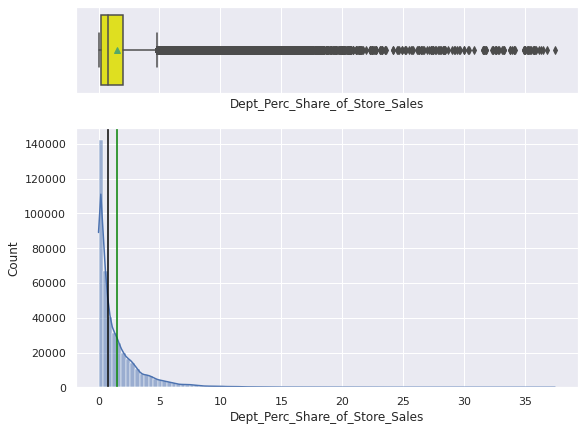

In [ ]:
HistBoxPlot(df, df.Dept_Perc_Share_of_Store_Sales, bins=100);



> **Of all reported sales from the departments of all stores, the mean contribution percentage of sales for a department is 1.5%. More than half of the reported sales are lower than the mean while half of the reported sales only contribute about 0.76%**



In [ ]:
df[df.Dept_Perc_Share_of_Store_Sales < .75].describe(include='all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
Store,208765.0,45.0,31.0,5668.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Type,208765,3,A,107872,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Size,208765.0,NaN,NaN,NaN,135586.786918,62127.135448,34875.0,93188.0,140167.0,202505.0,219622.0
Dept,208765.0,73.0,52.0,6266.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Date,208765,143,2012-01-13,1569,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Dept_Weekly_Sales,208765.0,NaN,NaN,NaN,3107.055864,3230.753033,0.0,501.27,2093.0,4686.24,27515.87
IsHoliday,208765,2,False,194030,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Temperature,208765.0,NaN,NaN,NaN,60.261579,18.51164,-2.06,46.85,62.34,74.64,100.14
Fuel_Price,208765.0,NaN,NaN,NaN,3.363346,0.457123,2.472,2.938,3.459,3.735,4.468
CPI,208765.0,NaN,NaN,NaN,171.537034,39.251931,126.064,131.735,182.622635,212.592862,227.232807




> **Further examination of the number data where a department contributes less than .75% reveals using this as a threshold could be useful as a classification.**



In [ ]:
# Organize the dataset from Store, Dept then Date
df = df.sort_values(by=['Store', 'Dept', 'Date'])
df.reset_index(inplace=True,drop=True)
df

,Store,Type,Size,Dept,Date,Dept_Weekly_Sales,IsHoliday,Temperature,Fuel_Price,CPI,Unemployment,Quarter,Quarter_Info,Store_Weekly_Sales,Dept_Perc_Share_of_Store_Sales
0,1,A,151315,1,2010-02-05,24924.50,False,42.31,2.572,211.096358,8.106,Q1,2010Q1,1643690.90,1.516374
1,1,A,151315,1,2010-02-12,46039.49,True,38.51,2.548,211.242170,8.106,Q1,2010Q1,1641957.44,2.803939
2,1,A,151315,1,2010-02-19,41595.55,False,39.93,2.514,211.289143,8.106,Q1,2010Q1,1611968.17,2.580420
3,1,A,151315,1,2010-02-26,19403.54,False,46.63,2.561,211.319643,8.106,Q1,2010Q1,1409727.59,1.376404
4,1,A,151315,1,2010-03-05,21827.90,False,46.50,2.625,211.350143,8.106,Q1,2010Q1,1554806.68,1.403898
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
420280,45,B,118221,98,2012-09-28,508.37,False,64.88,3.997,192.013558,8.684,Q3,2012Q3,713173.95,0.071283
420281,45,B,118221,98,2012-10-05,628.10,False,64.89,3.985,192.170412,8.667,Q4,2012Q4,733455.07,0.085636
420282,45,B,118221,98,2012-10-12,1061.02,False,54.47,4.000,192.327265,8.667,Q4,2012Q4,734464.36,0.144462
420283,45,B,118221,98,2012-10-19,760.01,False,56.47,3.969,192.330854,8.667,Q4,2012Q4,718125.53,0.105832


In [ ]:
df.columns

Index(['Store', 'Type', 'Size', 'Dept', 'Date', 'Dept_Weekly_Sales',
       'IsHoliday', 'Temperature', 'Fuel_Price', 'CPI', 'Unemployment',
       'Quarter', 'Quarter_Info', 'Store_Weekly_Sales',
       'Dept_Perc_Share_of_Store_Sales'],
      dtype='object')

In [ ]:
# Organize the columns based categorical and numerical variables
new_col = ['Date', 'Quarter', 'Quarter_Info', 'Store', 'Type', 'Size', 'Dept', 'Temperature',
           'Fuel_Price', 'CPI', 'Unemployment', 'IsHoliday', 'Store_Weekly_Sales', 'Dept_Weekly_Sales',
           'Dept_Perc_Share_of_Store_Sales']
df = df[new_col]
df

,Date,Quarter,Quarter_Info,Store,Type,Size,Dept,Temperature,Fuel_Price,CPI,Unemployment,IsHoliday,Store_Weekly_Sales,Dept_Weekly_Sales,Dept_Perc_Share_of_Store_Sales
0,2010-02-05,Q1,2010Q1,1,A,151315,1,42.31,2.572,211.096358,8.106,False,1643690.90,24924.50,1.516374
1,2010-02-12,Q1,2010Q1,1,A,151315,1,38.51,2.548,211.242170,8.106,True,1641957.44,46039.49,2.803939
2,2010-02-19,Q1,2010Q1,1,A,151315,1,39.93,2.514,211.289143,8.106,False,1611968.17,41595.55,2.580420
3,2010-02-26,Q1,2010Q1,1,A,151315,1,46.63,2.561,211.319643,8.106,False,1409727.59,19403.54,1.376404
4,2010-03-05,Q1,2010Q1,1,A,151315,1,46.50,2.625,211.350143,8.106,False,1554806.68,21827.90,1.403898
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
420280,2012-09-28,Q3,2012Q3,45,B,118221,98,64.88,3.997,192.013558,8.684,False,713173.95,508.37,0.071283
420281,2012-10-05,Q4,2012Q4,45,B,118221,98,64.89,3.985,192.170412,8.667,False,733455.07,628.10,0.085636
420282,2012-10-12,Q4,2012Q4,45,B,118221,98,54.47,4.000,192.327265,8.667,False,734464.36,1061.02,0.144462
420283,2012-10-19,Q4,2012Q4,45,B,118221,98,56.47,3.969,192.330854,8.667,False,718125.53,760.01,0.105832


In [ ]:
share_threshold = .75 # .75% or less
below_threshold = 1 # Dept in a given store should be downsized
above_threshold = 0 # Dept in a given store should NOT be downsized
df['Class_Downsize'] = np.where(df['Dept_Perc_Share_of_Store_Sales']<share_threshold, below_threshold, above_threshold)



> **Create labels for each record using the threshold .75% for a dept in a store for a given week to be downsized that week.**



### ***EDA Part 3***

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 420285 entries, 0 to 420284
Data columns (total 16 columns):
 #   Column                          Non-Null Count   Dtype   
---  ------                          --------------   -----   
 0   Date                            420285 non-null  object  
 1   Quarter                         420285 non-null  category
 2   Quarter_Info                    420285 non-null  category
 3   Store                           420285 non-null  category
 4   Type                            420285 non-null  category
 5   Size                            420285 non-null  int64   
 6   Dept                            420285 non-null  category
 7   Temperature                     420285 non-null  float64 
 8   Fuel_Price                      420285 non-null  float64 
 9   CPI                             420285 non-null  float64 
 10  Unemployment                    420285 non-null  float64 
 11  IsHoliday                       420285 non-null  category
 12  St

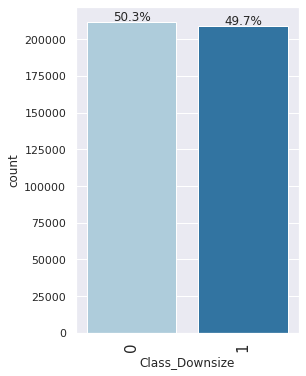

In [ ]:
labeled_barplot(df, "Class_Downsize", perc=True)



> **As designed, the class labels are split 50/50**



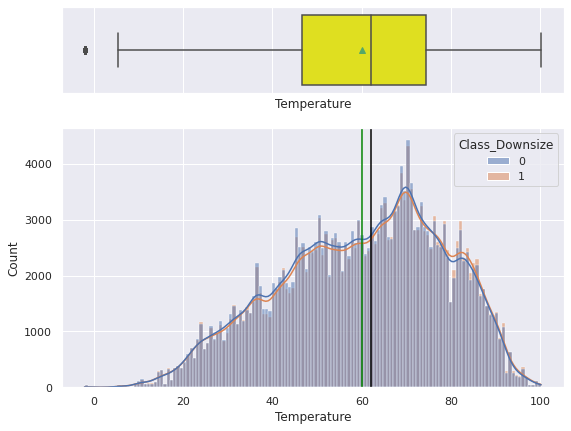

In [ ]:
HistBoxPlot(df, df.Temperature, df.Class_Downsize);

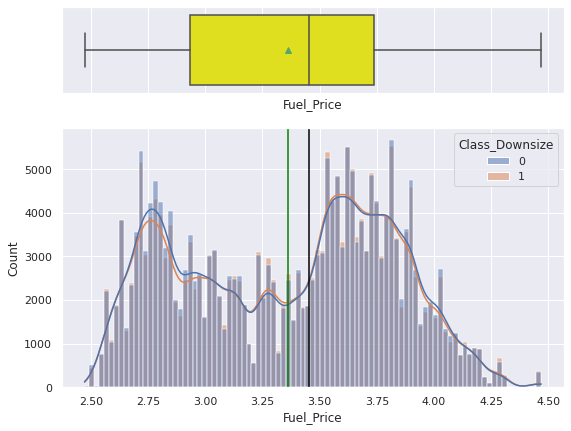

In [ ]:
HistBoxPlot(df, df.Fuel_Price, df.Class_Downsize);

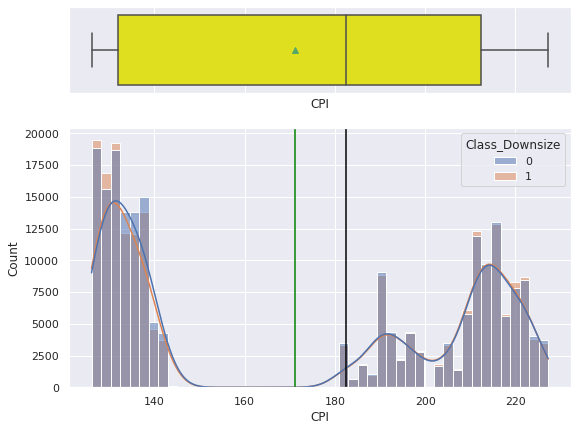

In [ ]:
HistBoxPlot(df, df.CPI, df.Class_Downsize);

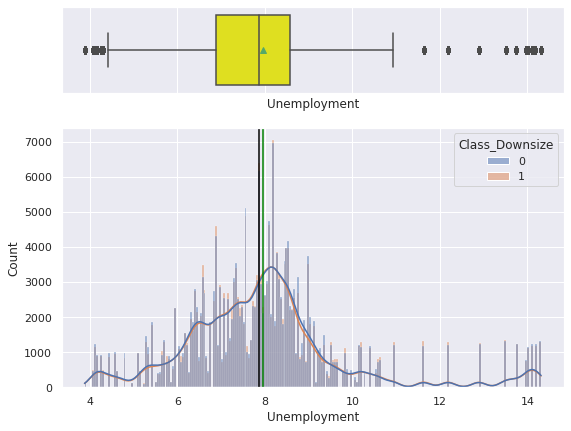

In [ ]:
HistBoxPlot(df, df.Unemployment, df.Class_Downsize);




> **At first glance, there appears to be no change in the numerical variables' distributions. Also it looks like the distributions for the classes are very close or equal**



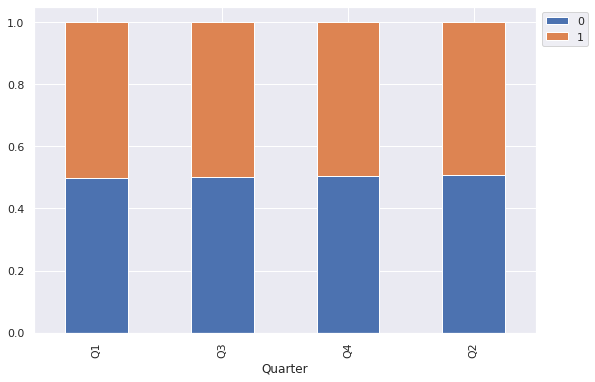

In [ ]:
stacked_barplot(df, "Quarter", "Class_Downsize")

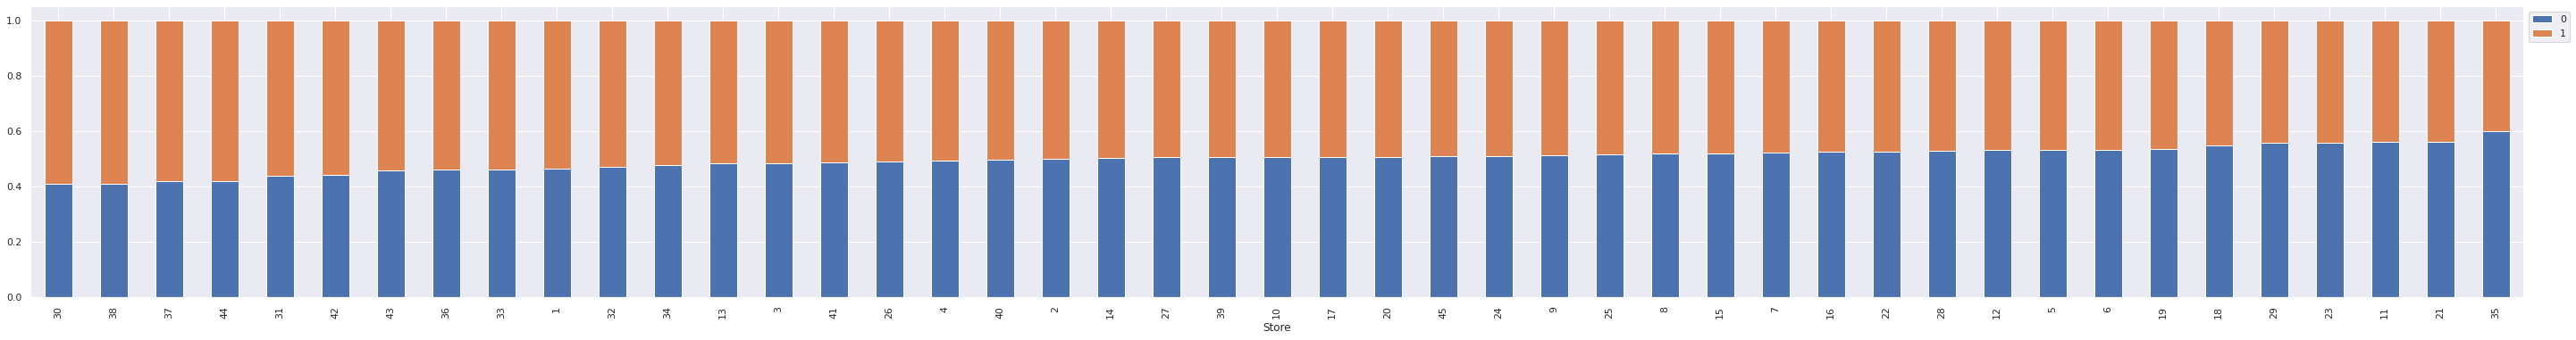

In [ ]:
stacked_barplot(df, "Store", "Class_Downsize")

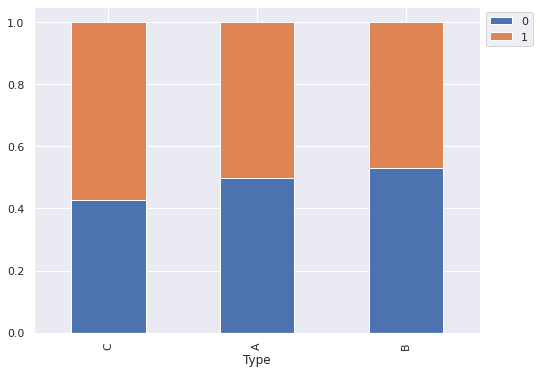

In [ ]:
stacked_barplot(df, "Type", "Class_Downsize")

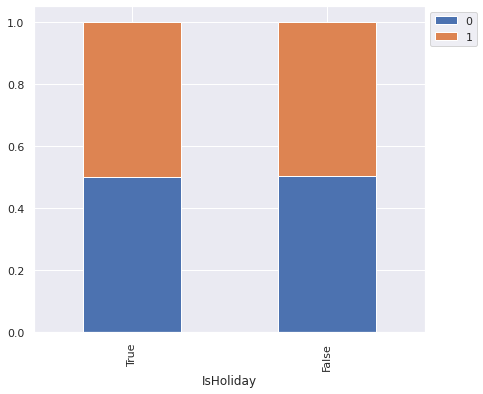

In [ ]:
stacked_barplot(df, "IsHoliday", "Class_Downsize")



> **All of the categorical variables above appear have close to equal class distributions.**



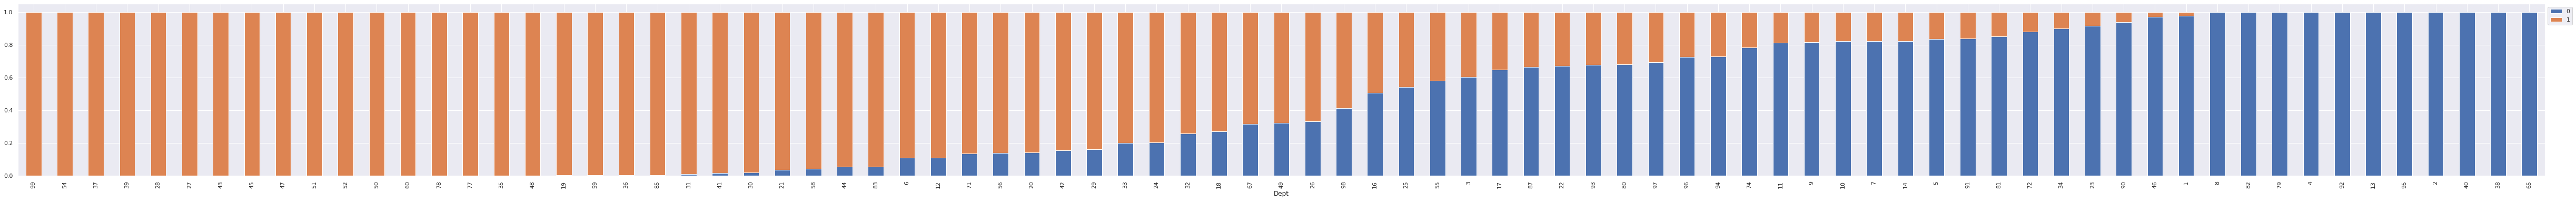

In [ ]:
stacked_barplot(df, "Dept", "Class_Downsize")



> **There are a few departments that are 100% classified.**



In [ ]:
#identify categorical features
df_categorical = df[['Quarter', 'Store', 'Type', 'Dept', 'IsHoliday', 'Class_Downsize']] 
categoritcal_features =  df_categorical.columns.values
comb = list(combinations(categoritcal_features, 2))

In [ ]:
for features in comb:

  # Contingency table of Purpose and Housing attributes
  crosstab = pd.crosstab(df[features[0]], df[features[1]])  

  Ho = "{} has NO effect on {} score".format(features[0], features[1])  # Stating the Null Hypothesis
  Ha = "{} has an effect on {} score".format(features[0], features[1])   # Stating the Alternate Hypothesis

  chi, p_value, dof, expected = stats.chi2_contingency(crosstab)

  if p_value < 0.05:  # Setting our significance level at 5%
      print(f"-----> {Ha} as the p_value ({p_value.round(3)}) < 0.05\n")
  else:
      print(f"{Ho} as the p_value ({p_value.round(3)}) > 0.05\n")
  

Quarter has NO effect on Store score as the p_value (1.0) > 0.05

Quarter has NO effect on Type score as the p_value (0.852) > 0.05

-----> Quarter has an effect on Dept score as the p_value (0.0) < 0.05

-----> Quarter has an effect on IsHoliday score as the p_value (0.0) < 0.05

-----> Quarter has an effect on Class_Downsize score as the p_value (0.001) < 0.05

-----> Store has an effect on Type score as the p_value (0.0) < 0.05

-----> Store has an effect on Dept score as the p_value (0.0) < 0.05

Store has NO effect on IsHoliday score as the p_value (1.0) > 0.05

-----> Store has an effect on Class_Downsize score as the p_value (0.0) < 0.05

-----> Type has an effect on Dept score as the p_value (0.0) < 0.05

Type has NO effect on IsHoliday score as the p_value (0.776) > 0.05

-----> Type has an effect on Class_Downsize score as the p_value (0.0) < 0.05

-----> Dept has an effect on IsHoliday score as the p_value (0.0) < 0.05

-----> Dept has an effect on Class_Downsize score as th



> **There appears to be significant evidence to support that a few categorical variables have influences on one another.**



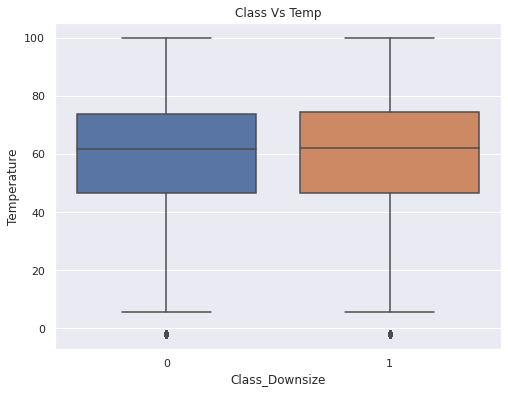

In [ ]:
plt.figure(figsize=(8, 6))
sns.boxplot(x="Class_Downsize", y="Temperature", data=df).set(title="Class Vs Temp");

In [ ]:
feature_0 =  df[(df.Class_Downsize == 0)].Temperature
feature_1 =  df[(df.Class_Downsize == 1)].Temperature
mean_1 = feature_0.mean()
mean_2 = feature_1.mean()
std_1 = feature_0.std()
std_2 = feature_1.std()

# find the sample means and sample standard deviations for the two samples
print('The mean Temperature of those labeled DO NOT DOWNSIZE is ' + str(mean_1))
print('The mean Temperature of those labeled as DOWNSIZE is ' + str(mean_2))
print('The standard deviation of Temperature of those labeled DO NOT DOWNSIZE is ' + str(round(std_1,4)))
print('The standard deviation of Temperature of those labeled as DOWNSIZE is ' + str(round(std_2,4)))

# find the p-value
test_stat, p_value = ttest_ind(feature_0, feature_1, equal_var = True, alternative = 'two-sided')
print('\nThe p-value is', p_value)
if p_value < .05:
  print('Significant Difference between Means (u1 does not equal u2)')
else:
  print('No Significant Difference between Means (u1 equal u2)')


The mean Temperature of those labeled DO NOT DOWNSIZE is 59.921598477685315
The mean Temperature of those labeled as DOWNSIZE is 60.261579096112854
The standard deviation of Temperature of those labeled DO NOT DOWNSIZE is 18.384
The standard deviation of Temperature of those labeled as DOWNSIZE is 18.5116

The p-value is 2.3200239010466023e-09
Significant Difference between Means (u1 does not equal u2)


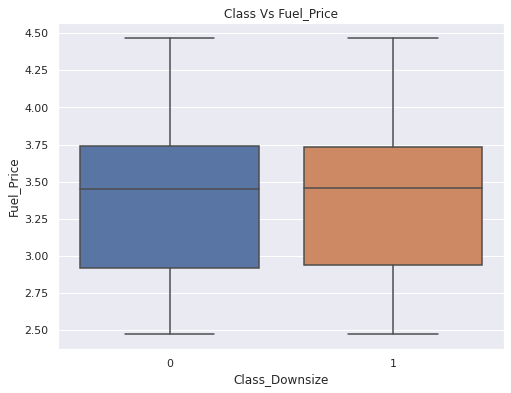

In [ ]:
plt.figure(figsize=(8, 6))
sns.boxplot(x="Class_Downsize", y="Fuel_Price", data=df).set(title="Class Vs Fuel_Price");

In [ ]:
feature_0 =  df[(df.Class_Downsize == 0)].Fuel_Price
feature_1 =  df[(df.Class_Downsize == 1)].Fuel_Price
mean_1 = feature_0.mean()
mean_2 = feature_1.mean()
std_1 = feature_0.std()
std_2 = feature_1.std()

# find the sample means and sample standard deviations for the two samples
print('The mean Fuel_Price of those labeled DO NOT DOWNSIZE is ' + str(mean_1))
print('The mean Fuel_Price of those labeled as DOWNSIZE is ' + str(mean_2))
print('The standard deviation of Fuel_Price of those labeled DO NOT DOWNSIZE is ' + str(round(std_1,4)))
print('The standard deviation of Fuel_Price of those labeled as DOWNSIZE is ' + str(round(std_2,4)))

# find the p-value
test_stat, p_value = ttest_ind(feature_0, feature_1, equal_var = True, alternative = 'two-sided')
print('\nThe p-value is', p_value)
if p_value < .05:
  print('Significant Difference between Means (u1 does not equal u2)')
else:
  print('No Significant Difference between Means (u1 equal u2)')

The mean Fuel_Price of those labeled DO NOT DOWNSIZE is 3.35846264183056
The mean Fuel_Price of those labeled as DOWNSIZE is 3.363345627859076
The standard deviation of Fuel_Price of those labeled DO NOT DOWNSIZE is 0.4599
The standard deviation of Fuel_Price of those labeled as DOWNSIZE is 0.4571

The p-value is 0.0005566310712351954
Significant Difference between Means (u1 does not equal u2)


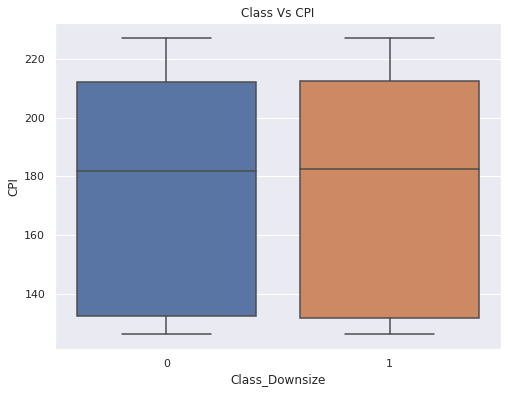

In [ ]:
plt.figure(figsize=(8, 6))
sns.boxplot(x="Class_Downsize", y="CPI", data=df).set(title="Class Vs CPI");

In [ ]:
feature_0 =  df[(df.Class_Downsize == 0)].CPI
feature_1 =  df[(df.Class_Downsize == 1)].CPI
mean_1 = feature_0.mean()
mean_2 = feature_1.mean()
std_1 = feature_0.std()
std_2 = feature_1.std()

# find the sample means and sample standard deviations for the two samples
print('The mean CPI of those labeled DO NOT DOWNSIZE is ' + str(mean_1))
print('The mean CPI of those labeled as DOWNSIZE is ' + str(mean_2))
print('The standard deviation of CPI of those labeled DO NOT DOWNSIZE is ' + str(round(std_1,4)))
print('The standard deviation of CPI of those labeled as DOWNSIZE is ' + str(round(std_2,4)))

# find the p-value
test_stat, p_value = ttest_ind(feature_0, feature_1, equal_var = True, alternative = 'two-sided')
print('\nThe p-value is', p_value)
if p_value < .05:
  print('Significant Difference between Means (u1 does not equal u2)')
else:
  print('No Significant Difference between Means (u1 equal u2)')

The mean CPI of those labeled DO NOT DOWNSIZE is 170.89150052114888
The mean CPI of those labeled as DOWNSIZE is 171.53703400894693
The standard deviation of CPI of those labeled DO NOT DOWNSIZE is 39.071
The standard deviation of CPI of those labeled as DOWNSIZE is 39.2519

The p-value is 9.139061607778446e-08
Significant Difference between Means (u1 does not equal u2)


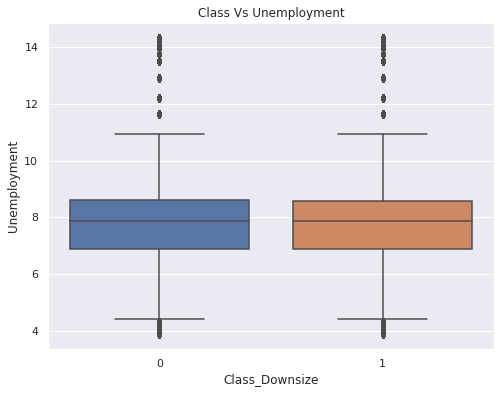

In [ ]:
plt.figure(figsize=(8, 6))
sns.boxplot(x="Class_Downsize", y="Unemployment", data=df).set(title="Class Vs Unemployment");

In [ ]:
feature_0 =  df[(df.Class_Downsize == 0)].Unemployment
feature_1 =  df[(df.Class_Downsize == 1)].Unemployment
mean_1 = feature_0.mean()
mean_2 = feature_1.mean()
std_1 = feature_0.std()
std_2 = feature_1.std()

# find the sample means and sample standard deviations for the two samples
print('The mean Unemployment of those labeled DO NOT DOWNSIZE is ' + str(mean_1))
print('The mean Unemployment of those labeled as DOWNSIZE is ' + str(mean_2))
print('The standard deviation of Unemployment of those labeled DO NOT DOWNSIZE is ' + str(round(std_1,4)))
print('The standard deviation of Unemployment of those labeled as DOWNSIZE is ' + str(round(std_2,4)))

# find the p-value
test_stat, p_value = ttest_ind(feature_0, feature_1, equal_var = True, alternative = 'two-sided')
print('\nThe p-value is', p_value)
if p_value < .05:
  print('Significant Difference between Means (u1 does not equal u2)')
else:
  print('No Significant Difference between Means (u1 equal u2)')

The mean Unemployment of those labeled DO NOT DOWNSIZE is 7.957516026853252
The mean Unemployment of those labeled as DOWNSIZE is 7.962671717002371
The standard deviation of Unemployment of those labeled DO NOT DOWNSIZE is 1.8663
The standard deviation of Unemployment of those labeled as DOWNSIZE is 1.8614

The p-value is 0.3699283014897957
No Significant Difference between Means (u1 equal u2)




> **There is siginificant evidence to suggest that the Unemployment Rate Means are not different from their class equivalencies. However, there is evidence that suggest Temp mean, CPI mean and Fuel Price mean for the classes are different**


### ***Finalize Features***

In [ ]:
df.columns

Index(['Date', 'Quarter', 'Quarter_Info', 'Store', 'Type', 'Size', 'Dept',
       'Temperature', 'Fuel_Price', 'CPI', 'Unemployment', 'IsHoliday',
       'Store_Weekly_Sales', 'Dept_Weekly_Sales',
       'Dept_Perc_Share_of_Store_Sales', 'Class_Downsize'],
      dtype='object')

In [ ]:
# Date, Quarter_Info and stats about the performance of a dept in a store are not required for this classification model
df_features = df.drop(columns=['Date', 'Quarter_Info', 'Store_Weekly_Sales', 'Dept_Weekly_Sales', 'Dept_Perc_Share_of_Store_Sales'])

In [ ]:
df_features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 420285 entries, 0 to 420284
Data columns (total 11 columns):
 #   Column          Non-Null Count   Dtype   
---  ------          --------------   -----   
 0   Quarter         420285 non-null  category
 1   Store           420285 non-null  category
 2   Type            420285 non-null  category
 3   Size            420285 non-null  int64   
 4   Dept            420285 non-null  category
 5   Temperature     420285 non-null  float64 
 6   Fuel_Price      420285 non-null  float64 
 7   CPI             420285 non-null  float64 
 8   Unemployment    420285 non-null  float64 
 9   IsHoliday       420285 non-null  category
 10  Class_Downsize  420285 non-null  int64   
dtypes: category(5), float64(4), int64(2)
memory usage: 21.2 MB




> **The final dataframe has five categorical features (before dummy variables) and five numerical features.**



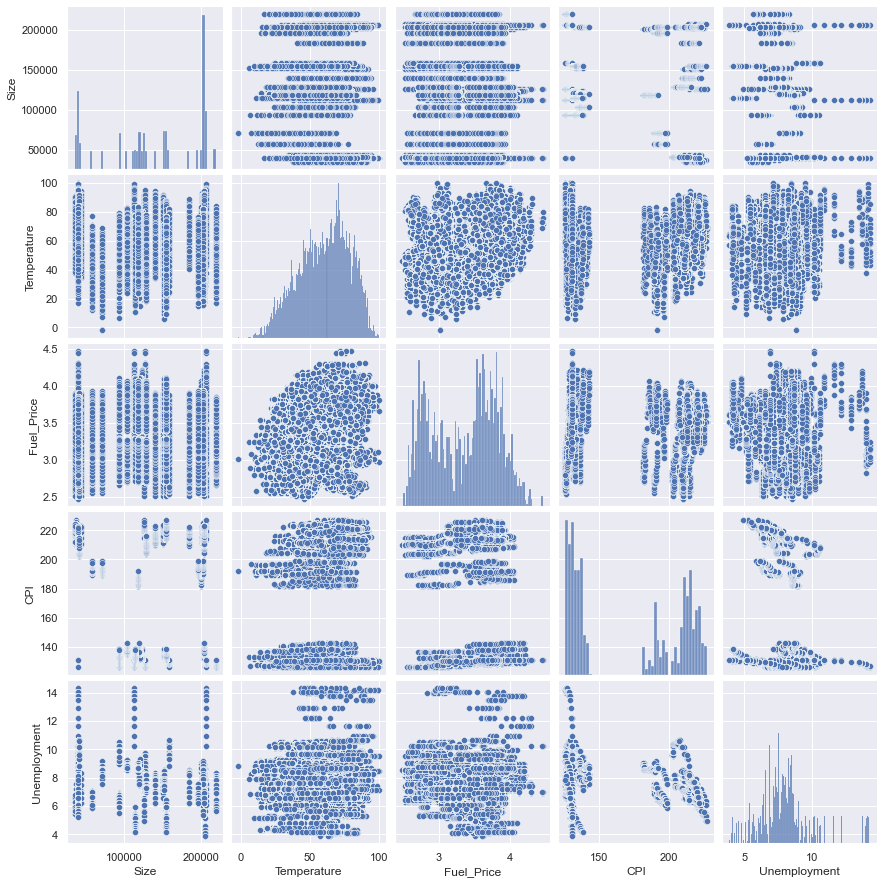

In [ ]:
numerical_df = df_features[['Size', 'Dept','Temperature', 'Fuel_Price', 'CPI', 'Unemployment']]
sns.pairplot(numerical_df);

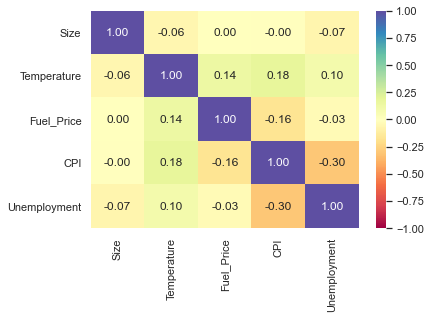

In [ ]:
# Studying correlation among numeric variables
sns.heatmap(numerical_df.corr(), annot=True, vmin=-1, vmax=1, fmt=".2f", cmap="Spectral");



> **There is little to no correlation between the numerical variables. Slight variations appear to suggest there is relationship between CPI and Unemployment, Temp and Fuel Price, Temp and CPI, Fuel and CPI**



### ***Dummy Variables and Split Data***

In [ ]:
df_w_dummies = pd.get_dummies(df_features, drop_first=True)
df_w_dummies.dtypes

Size                int64
Temperature       float64
Fuel_Price        float64
CPI               float64
Unemployment      float64
Class_Downsize      int64
Quarter_Q2          uint8
Quarter_Q3          uint8
Quarter_Q4          uint8
Store_2             uint8
Store_3             uint8
Store_4             uint8
Store_5             uint8
Store_6             uint8
Store_7             uint8
Store_8             uint8
Store_9             uint8
Store_10            uint8
Store_11            uint8
Store_12            uint8
Store_13            uint8
Store_14            uint8
Store_15            uint8
Store_16            uint8
Store_17            uint8
Store_18            uint8
Store_19            uint8
Store_20            uint8
Store_21            uint8
Store_22            uint8
Store_23            uint8
Store_24            uint8
Store_25            uint8
Store_26            uint8
Store_27            uint8
Store_28            uint8
Store_29            uint8
Store_30            uint8
Store_31    

In [ ]:
# Separated the predictor and target variable
X = df_w_dummies.drop(["Class_Downsize"], axis=1)
y = df_w_dummies["Class_Downsize"]

In [ ]:
feature_names = list(X.columns)
len(feature_names)

135



> **135 Features**



In [ ]:
# split 70/30 - split the data in train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42, stratify=y)

In [ ]:
print("Number of rows in train data =", X_train.shape[0])
print("Number of rows in test data =", X_test.shape[0])

Number of rows in train data = 294199
Number of rows in test data = 126086




> **Results from 70/30 Split**



In [ ]:
y.value_counts(1)

0    0.503278
1    0.496722
Name: Class_Downsize, dtype: float64

In [ ]:
y_test.value_counts(1)

0    0.503276
1    0.496724
Name: Class_Downsize, dtype: float64



> **Class distributions close enough for Training and Test Data**



### ***Models***

#### ***Decision Tree***

In [ ]:
dTree = DecisionTreeClassifier(random_state=42)
dTree.fit(X_train, y_train);

Decision Tree Results 
            Train      Test
Accuracy     1.0  0.962042
Recall       1.0  0.962590
Precision    1.0  0.961055
F1           1.0  0.961822 



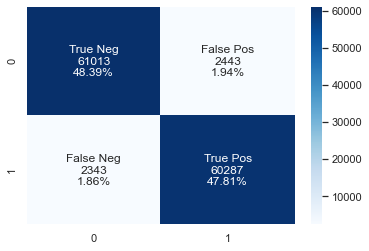

In [ ]:
dTree_train_results = model_performance_classification(dTree, X_train, y_train)
dTree_test_results = model_performance_classification(dTree, X_test, y_test)
dTreeResults = pd.concat([dTree_train_results, dTree_test_results], ignore_index=True).rename(index={0: 'Train', 1: 'Test'})
print('Decision Tree Results \n', dTreeResults.T, '\n')
make_confusion_matrix(dTree, X_test, y_test);

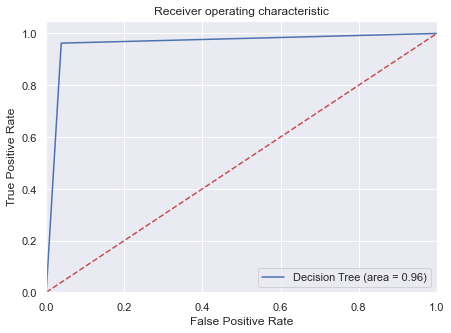

In [ ]:
dTree_roc_auc_train = roc_auc_score(y_test, dTree.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test, dTree.predict(X_test))
plt.figure(figsize=(7, 5))
plt.plot(fpr, tpr, label="Decision Tree (area = %0.2f)" % dTree_roc_auc_train)
plt.plot([0, 1], [0, 1], "r--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver operating characteristic")
plt.legend(loc="lower right")
plt.show()



> **Training Overfit yet Test Data performed well**



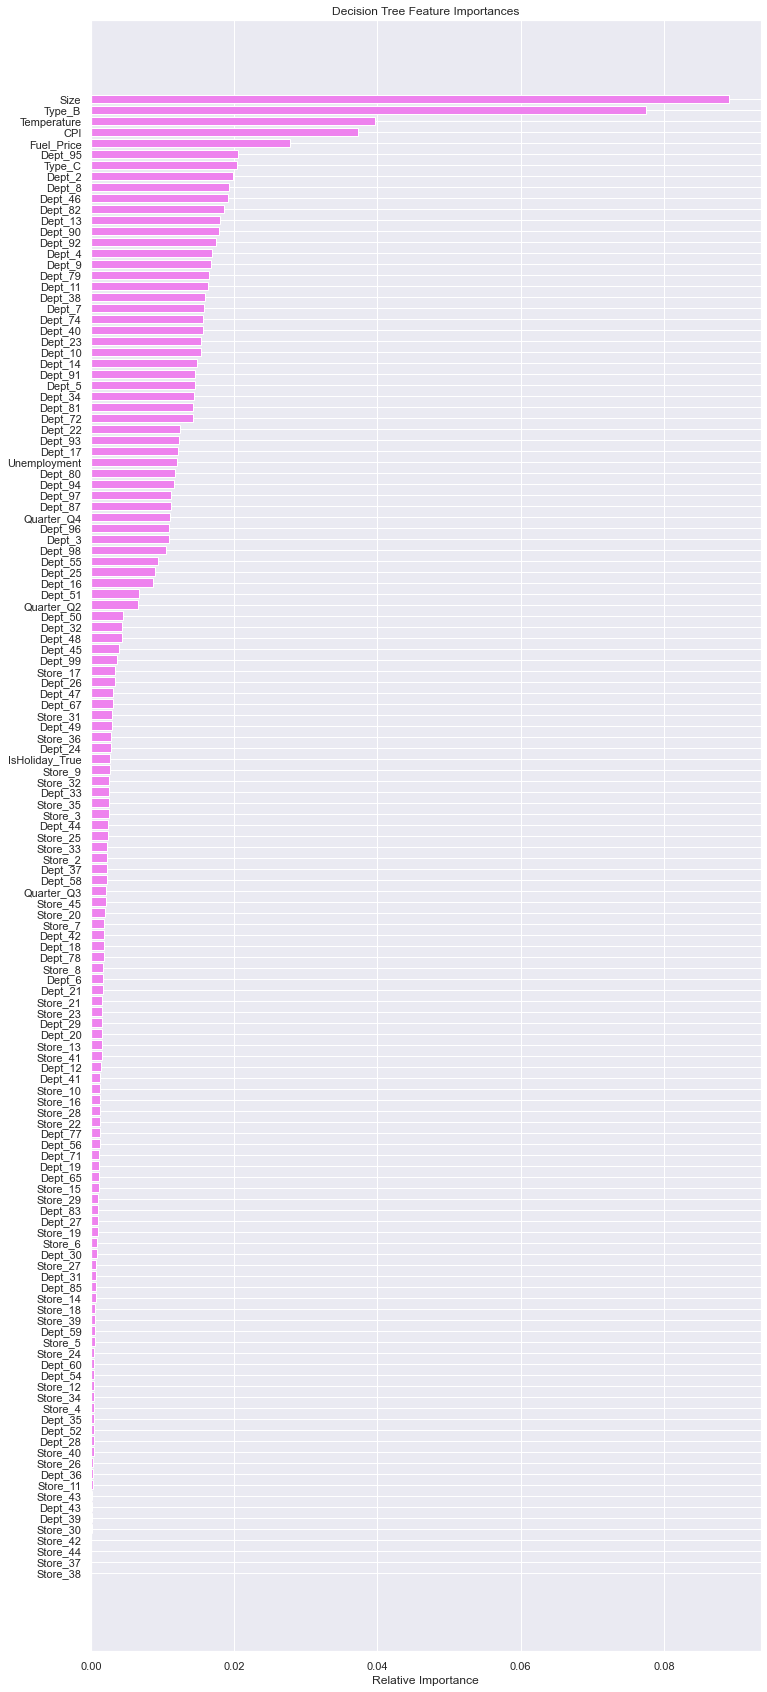

In [ ]:
importances = dTree.feature_importances_
indices = np.argsort(importances)

plt.figure(figsize=(12, 30))
plt.title("Decision Tree Feature Importances")
plt.barh(range(len(indices)), importances[indices], color="violet", align="center")
plt.yticks(range(len(indices)), [feature_names[i] for i in indices])
plt.xlabel("Relative Importance")
plt.show()

#### ***Random Forest***

In [ ]:
rf_estimator = RandomForestClassifier(random_state=42)
rf_estimator.fit(X_train,y_train);

Random Forest Results 
            Train      Test
Accuracy     1.0  0.967831
Recall       1.0  0.968114
Precision    1.0  0.967157
F1           1.0  0.967635 



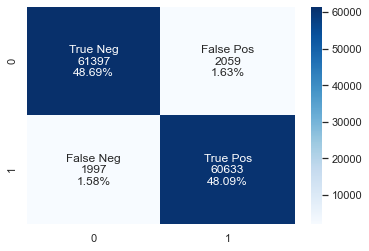

In [ ]:
rf_train_results = model_performance_classification(rf_estimator, X_train, y_train)
rf_test_results = model_performance_classification(rf_estimator, X_test, y_test)
rfResults = pd.concat([rf_train_results, rf_test_results], ignore_index=True).rename(index={0: 'Train', 1: 'Test'})
print('Random Forest Results \n', rfResults.T, '\n')
make_confusion_matrix(rf_estimator, X_test, y_test);

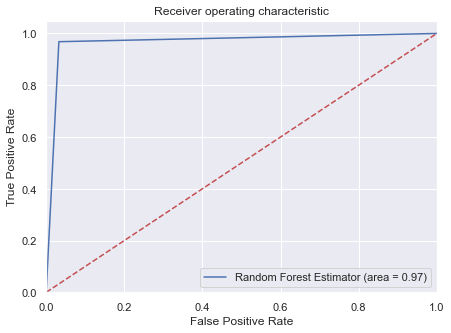

In [ ]:
rf_estimator_roc_auc_train = roc_auc_score(y_test, rf_estimator.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test, rf_estimator.predict(X_test))
plt.figure(figsize=(7, 5))
plt.plot(fpr, tpr, label="Random Forest Estimator (area = %0.2f)" % rf_estimator_roc_auc_train)
plt.plot([0, 1], [0, 1], "r--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver operating characteristic")
plt.legend(loc="lower right")
plt.show()



> **Just like the Decision Tree, Training Overfit yet Test Data performed well**


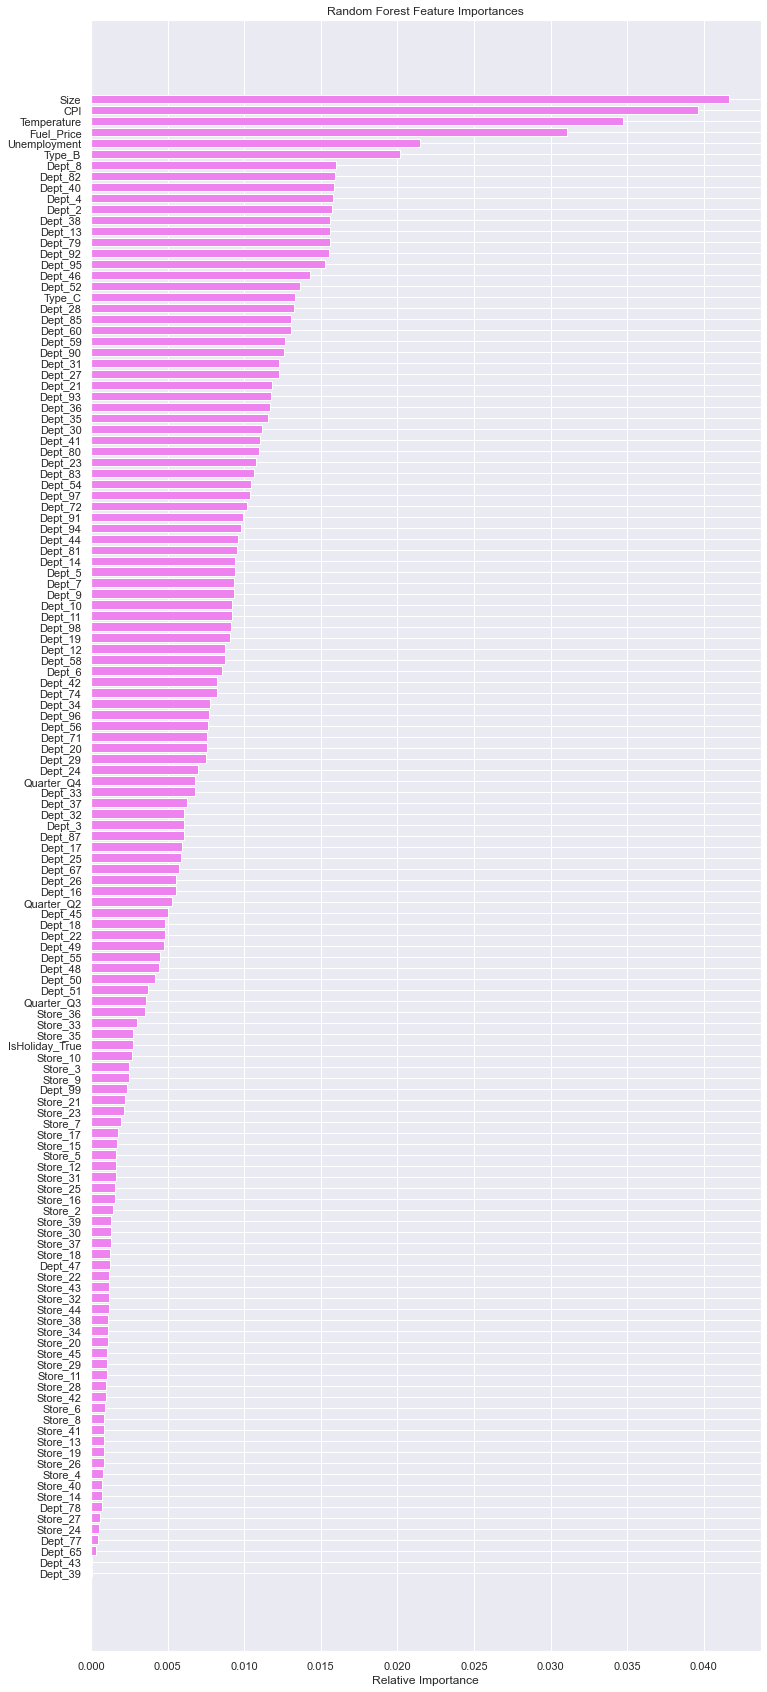

In [ ]:
importances = rf_estimator.feature_importances_
indices = np.argsort(importances)

plt.figure(figsize=(12, 30))
plt.title("Random Forest Feature Importances")
plt.barh(range(len(indices)), importances[indices], color="violet", align="center")
plt.yticks(range(len(indices)), [feature_names[i] for i in indices])
plt.xlabel("Relative Importance")
plt.show()



> **Numerical Variables dominated the feature importance**



#### ***Bagging***

In [ ]:
#Fitting the model
bagging_classifier = BaggingClassifier(random_state=42)
bagging_classifier.fit(X_train,y_train);

Bagging Results 
               Train      Test
Accuracy   0.997420  0.966824
Recall     0.996366  0.964171
Precision  0.998437  0.968889
F1         0.997400  0.966524 



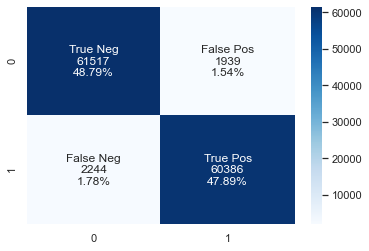

In [ ]:
bag_train_results = model_performance_classification(bagging_classifier, X_train, y_train)
bag_test_results = model_performance_classification(bagging_classifier, X_test, y_test)
bagResults = pd.concat([bag_train_results, bag_test_results], ignore_index=True).rename(index={0: 'Train', 1: 'Test'})
print('Bagging Results \n', bagResults.T, '\n')
make_confusion_matrix(bagging_classifier, X_test, y_test);

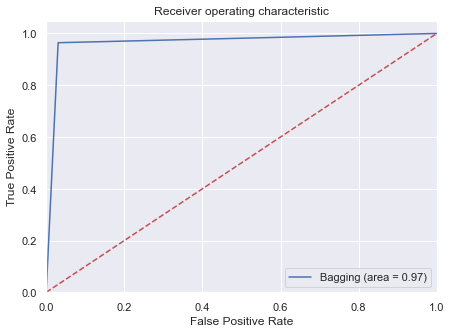

In [ ]:
bagging_roc_auc_train = roc_auc_score(y_test, bagging_classifier.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test, bagging_classifier.predict(X_test))
plt.figure(figsize=(7, 5))
plt.plot(fpr, tpr, label="Bagging (area = %0.2f)" % bagging_roc_auc_train)
plt.plot([0, 1], [0, 1], "r--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver operating characteristic")
plt.legend(loc="lower right")
plt.show()



> **Slight signs of overfitting yet test data once again performed well**



### ***Comparison of Models***

In [ ]:
train_models_comp_df = pd.concat(
    [dTree_train_results.T, rf_train_results.T, bag_train_results.T],
    axis=1,
)
train_models_comp_df.columns = ["DTree", "RF", "Bagging"]
print("Performance Comparison: Train")
round(train_models_comp_df, 4).style.highlight_max(color="lightgreen", axis=1)

Performance Comparison: Train


,DTree,RF,Bagging
Accuracy,1.000000,1.000000,0.997400
Recall,1.000000,1.000000,0.996400
Precision,1.000000,1.000000,0.998400
F1,1.000000,1.000000,0.997400


In [ ]:
test_models_comp_df = pd.concat(
    [dTree_test_results.T,rf_test_results.T, bag_test_results.T],
    axis=1,
)
test_models_comp_df.columns = ["DTree","RF", "Bagging"]
print("Performance Comparison: Test")
round(test_models_comp_df, 4).style.highlight_max(color="lightgreen", axis=1)

Performance Comparison: Test


,DTree,RF,Bagging
Accuracy,0.962000,0.967800,0.966800
Recall,0.962600,0.968100,0.964200
Precision,0.961100,0.967200,0.968900
F1,0.961800,0.967600,0.966500


In [ ]:
models_comp_df = round((test_models_comp_df - train_models_comp_df), 4)

print("Delta Comparison between Train and Test")
models_comp_df.style.highlight_max(color="lightgreen", axis=1)

Delta Comparison between Train and Test


,DTree,RF,Bagging
Accuracy,-0.038000,-0.032200,-0.030600
Recall,-0.037400,-0.031900,-0.032200
Precision,-0.038900,-0.032800,-0.029500
F1,-0.038200,-0.032400,-0.030900




> **Without tuning, Bagging seems to be the best choice for this dataset. F1 Score was of utmost importance; however, all other metrics did very well. Also, Bagging had the least overfitting with the training data.**



### ***Tuning and Comparison of Tuned Models***

#### ***DT Tuned Model***

In [ ]:
#Choose the type of classifier. 
dtree_base = DecisionTreeClassifier(random_state=42)

parameters = {'min_samples_leaf': [0.7,0.8,0.9,1],
              'min_impurity_decrease': [0.001, 0.01, 0.1]
              }

# Type of scoring used to compare parameter combinations
scorer = make_scorer(f1_score)

# Run the grid search or run random search
#cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=10, random_state=42)
grid_obj = GridSearchCV(dtree_base, parameters, scoring=scorer, cv=5, n_jobs=-1)

%time grid_obj = grid_obj.fit(X_train, y_train)

# Set the clf to the best combination of parameters
dtree_tuned = grid_obj.best_estimator_

# Fit the best algorithm to the data. 
dtree_tuned.fit(X_train, y_train)

CPU times: user 10 s, sys: 662 ms, total: 10.7 s
Wall time: 51.1 s


DecisionTreeClassifier(min_impurity_decrease=0.001, random_state=42)

Decision Tree Tuned Results 
        Accuracy    Recall  Precision        F1
Train  0.904901  0.921709   0.890651  0.905914
Test   0.904716  0.920214   0.891462  0.905610 



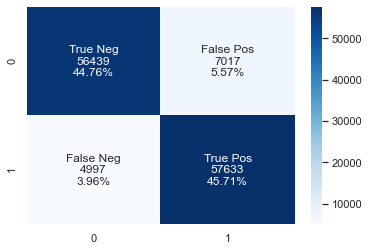

In [ ]:
dTreeTuned_train_results = model_performance_classification(dtree_tuned, X_train, y_train)
dTreeTuned_test_results = model_performance_classification(dtree_tuned, X_test, y_test)
dTreeTunedResults = pd.concat([dTreeTuned_train_results, dTreeTuned_test_results], ignore_index=True).rename(index={0: 'Train', 1: 'Test'})
print('Decision Tree Tuned Results \n', dTreeTunedResults, '\n')
make_confusion_matrix(dtree_tuned, X_test, y_test)

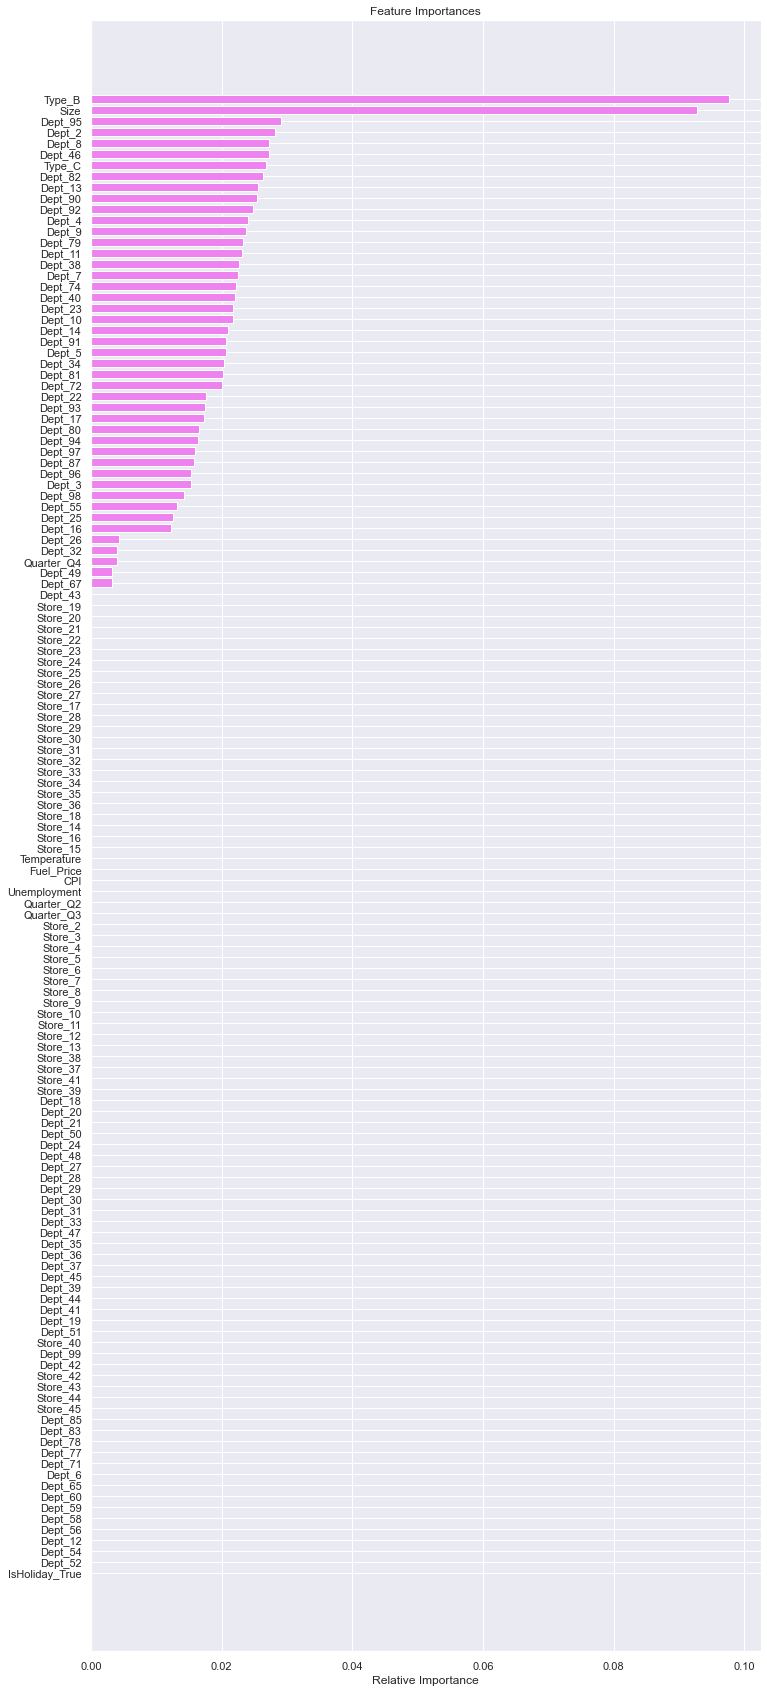

In [ ]:
importances = dtree_tuned.feature_importances_
indices = np.argsort(importances)

plt.figure(figsize=(12, 30))
plt.title("Feature Importances")
plt.barh(range(len(indices)), importances[indices], color="violet", align="center")
plt.yticks(range(len(indices)), [feature_names[i] for i in indices])
plt.xlabel("Relative Importance")
plt.show()

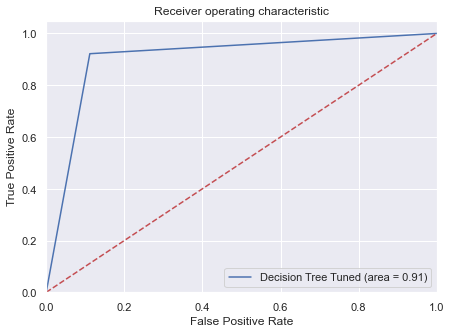

In [ ]:
dTreeTuned_roc_auc_train = roc_auc_score(y_train, dtree_tuned.predict(X_train))
fpr, tpr, thresholds = roc_curve(y_train, dtree_tuned.predict(X_train))
plt.figure(figsize=(7, 5))
plt.plot(fpr, tpr, label="Decision Tree Tuned (area = %0.2f)" % dTreeTuned_roc_auc_train)
plt.plot([0, 1], [0, 1], "r--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver operating characteristic")
plt.legend(loc="lower right")
plt.show()

#### ***RF Tuned Model***

In [ ]:
#Choose the type of classifier. 
rf_estimator_base = RandomForestClassifier(random_state=42)

parameters = {  
                'max_features': [0.7,0.8,0.9,1],
                'max_samples': [0.7,0.8,0.9,1], 
                'n_estimators': [10,20,30,40,50],
                'min_impurity_decrease': [0.001,0.01,0.1]
              }

# Type of scoring used to compare parameter combinations
scorer = make_scorer(f1_score)

# Run the grid search or run random search
#cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=10, random_state=42)
grid_obj = GridSearchCV(rf_estimator_base, parameters, scoring=scorer, cv=5, n_jobs=-1)

%time grid_obj = grid_obj.fit(X_train, y_train)

# Set the clf to the best combination of parameters
rf_estimator_tuned = grid_obj.best_estimator_

# Fit the best algorithm to the data. 
rf_estimator_tuned.fit(X_test, y_test)

CPU times: user 1min 22s, sys: 5.53 s, total: 1min 27s
Wall time: 2h 40min 15s


RandomForestClassifier(max_features=0.7, max_samples=0.8,
                       min_impurity_decrease=0.001, n_estimators=20,
                       random_state=42)

Random Forest Tuned Results 
        Accuracy    Recall  Precision        F1
Train  0.903858  0.935498   0.878773  0.906249
Test   0.905152  0.935606   0.880853  0.907404 



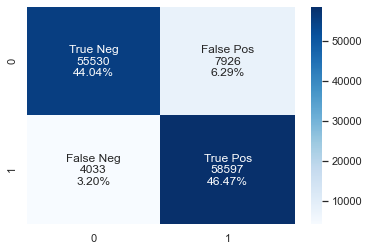

In [ ]:
rfTuned_train_results = model_performance_classification(rf_estimator_tuned, X_train, y_train)
rfTuned_test_results = model_performance_classification(rf_estimator_tuned, X_test, y_test)
rfTunedResults = pd.concat([rfTuned_train_results, rfTuned_test_results], ignore_index=True).rename(index={0: 'Train', 1: 'Test'})
print('Random Forest Tuned Results \n', rfTunedResults, '\n')
make_confusion_matrix(rf_estimator_tuned, X_test, y_test)

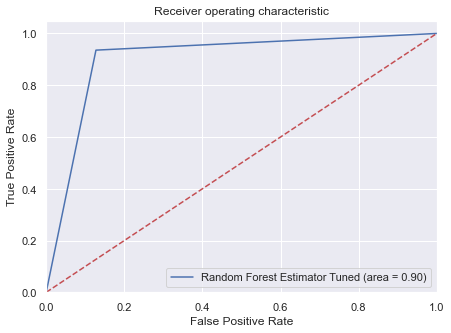

In [ ]:
rfTuned_roc_auc_train = roc_auc_score(y_train, rf_estimator_tuned.predict(X_train))
fpr, tpr, thresholds = roc_curve(y_train, rf_estimator_tuned.predict(X_train))
plt.figure(figsize=(7, 5))
plt.plot(fpr, tpr, label="Random Forest Estimator Tuned (area = %0.2f)" % rfTuned_roc_auc_train)
plt.plot([0, 1], [0, 1], "r--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver operating characteristic")
plt.legend(loc="lower right")
plt.show()

#### ***Bagging Tuned Model***

In [ ]:
# Choose the type of classifier. 
bagging_estimator_base = BaggingClassifier(random_state=1)

# Grid of parameters to choose from
parameters = {'max_samples': [0.7,0.8,0.9,1], 
              'max_features': [0.7,0.8,0.9,1],
              'n_estimators' : [10,20,30,40,50]
             }

# Type of scoring used to compare parameter combinations
scorer = make_scorer(f1_score)

# Run the grid search or run random search
#cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=10, random_state=42)
grid_obj = GridSearchCV(bagging_estimator_base, parameters, scoring=scorer, cv=5, n_jobs=-1)

%time grid_obj = grid_obj.fit(X_train, y_train)

# Set the clf to the best combination of parameters
bagging_estimator_tuned = grid_obj.best_estimator_

# Fit the best algorithm to the data. 
bagging_estimator_tuned.fit(X_test, y_test)

CPU times: user 3min 18s, sys: 6.52 s, total: 3min 25s
Wall time: 2h 57min 26s


BaggingClassifier(max_features=0.9, max_samples=0.7, n_estimators=40,
                  random_state=1)

Bagging Tuned Results 
        Accuracy    Recall  Precision        F1
Train  0.960163  0.965744   0.954587  0.960133
Test   0.996859  0.997078   0.996601  0.996839 



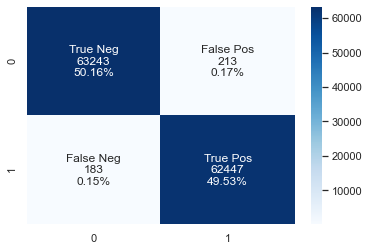

In [ ]:
bTuned_train_results = model_performance_classification(bagging_estimator_tuned, X_train, y_train)
bTuned_test_results = model_performance_classification(bagging_estimator_tuned, X_test, y_test)
bTunedResults = pd.concat([bTuned_train_results, bTuned_test_results], ignore_index=True).rename(index={0: 'Train', 1: 'Test'})
print('Bagging Tuned Results \n', bTunedResults, '\n')
make_confusion_matrix(bagging_estimator_tuned, X_test, y_test)

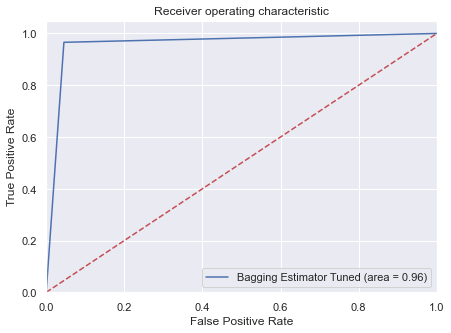

In [ ]:
bTuned_roc_auc_train = roc_auc_score(y_train, bagging_estimator_tuned.predict(X_train))
fpr, tpr, thresholds = roc_curve(y_train, bagging_estimator_tuned.predict(X_train))
plt.figure(figsize=(7, 5))
plt.plot(fpr, tpr, label="Bagging Estimator Tuned (area = %0.2f)" % bTuned_roc_auc_train)
plt.plot([0, 1], [0, 1], "r--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver operating characteristic")
plt.legend(loc="lower right")
plt.show()

#### ***Comparison: Untuned and Tuned***

In [ ]:
models_train_comp_df = pd.concat(
    [dTree_train_results.T, dTreeTuned_train_results.T,
     rf_train_results.T,rfTuned_train_results.T,
     bag_train_results.T,bTuned_train_results.T],
    axis=1,
)
models_train_comp_df.columns = ["DTree", "DTreeTuned", "RF","RFTuned", "Bag", "BagTuned"]
print("Train Performance Comparison")
round(models_train_comp_df, 4).style.highlight_max(color="lightgreen", axis=1)

Train Performance Comparison


,DTree,DTreeTuned,RF,RFTuned,Bag,BagTuned
Accuracy,1.000000,0.904900,1.000000,0.903900,0.997400,0.960200
Recall,1.000000,0.921700,1.000000,0.935500,0.996400,0.965700
Precision,1.000000,0.890700,1.000000,0.878800,0.998400,0.954600
F1,1.000000,0.905900,1.000000,0.906200,0.997400,0.960100


CPU times: user 282 ms, sys: 154 ms, total: 436 ms
Wall time: 441 ms
CPU times: user 247 ms, sys: 159 ms, total: 406 ms
Wall time: 486 ms
CPU times: user 10.5 s, sys: 247 ms, total: 10.7 s
Wall time: 10.8 s
CPU times: user 1.24 s, sys: 165 ms, total: 1.41 s
Wall time: 1.42 s
CPU times: user 2.71 s, sys: 1.64 s, total: 4.35 s
Wall time: 4.36 s
CPU times: user 9.89 s, sys: 5.73 s, total: 15.6 s
Wall time: 15.9 s


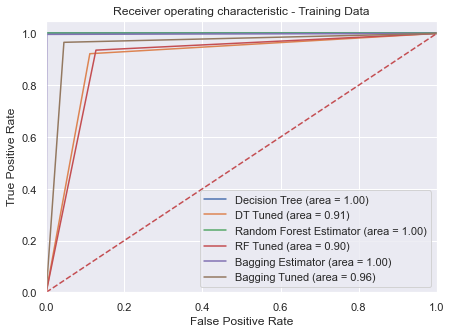

In [ ]:
plt.figure(figsize=(7, 5))

%time dTree_roc_auc_train = roc_auc_score(y_train, dTree.predict(X_train))
fpr, tpr, thresholds = roc_curve(y_train, dTree.predict(X_train))

plt.plot(fpr, tpr, label="Decision Tree (area = %0.2f)" % dTree_roc_auc_train)

%time dTreeTuned_roc_auc_train = roc_auc_score(y_train, dtree_tuned.predict(X_train))
fpr, tpr, thresholds = roc_curve(y_train, dtree_tuned.predict(X_train))

plt.plot(fpr, tpr, label="DT Tuned (area = %0.2f)" % dTreeTuned_roc_auc_train)

%time rf_roc_auc_train = roc_auc_score(y_train, rf_estimator.predict(X_train))
fpr, tpr, thresholds = roc_curve(y_train, rf_estimator.predict(X_train))

plt.plot(fpr, tpr, label="Random Forest Estimator (area = %0.2f)" % rf_roc_auc_train)

%time rfTuned_roc_auc_train = roc_auc_score(y_train, rf_estimator_tuned.predict(X_train))
fpr, tpr, thresholds = roc_curve(y_train, rf_estimator_tuned.predict(X_train))

plt.plot(fpr, tpr, label="RF Tuned (area = %0.2f)" % rfTuned_roc_auc_train)

%time bag_roc_auc_train = roc_auc_score(y_train, bagging_classifier.predict(X_train))
fpr, tpr, thresholds = roc_curve(y_train, bagging_classifier.predict(X_train))

plt.plot(fpr, tpr, label="Bagging Estimator (area = %0.2f)" % bag_roc_auc_train)

%time bagTuned_roc_auc_train = roc_auc_score(y_train, bagging_estimator_tuned.predict(X_train))
fpr, tpr, thresholds = roc_curve(y_train, bagging_estimator_tuned.predict(X_train))

plt.plot(fpr, tpr, label="Bagging Tuned (area = %0.2f)" % bagTuned_roc_auc_train)

plt.plot([0, 1], [0, 1], "r--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver operating characteristic - Training Data")
plt.legend(loc="lower right")
plt.show()

In [ ]:
models_test_comp_df = pd.concat(
    [dTree_test_results.T, dTreeTuned_test_results.T,
     rf_test_results.T,rfTuned_test_results.T,
     bag_test_results.T,bTuned_test_results.T],
    axis=1,
)
models_test_comp_df.columns = ["DTree", "DTreeTuned", "RF","RFTuned", "Bag", "BagTuned"]
print("Test Performance Comparison")
round(models_test_comp_df, 4).style.highlight_max(color="lightgreen", axis=1)

Test Performance Comparison


,DTree,DTreeTuned,RF,RFTuned,Bag,BagTuned
Accuracy,0.962000,0.904700,0.967800,0.905200,0.966800,0.996900
Recall,0.962600,0.920200,0.968100,0.935600,0.964200,0.997100
Precision,0.961100,0.891500,0.967200,0.880900,0.968900,0.996600
F1,0.961800,0.905600,0.967600,0.907400,0.966500,0.996800


CPU times: user 118 ms, sys: 61.7 ms, total: 179 ms
Wall time: 178 ms
CPU times: user 95.7 ms, sys: 47.7 ms, total: 143 ms
Wall time: 143 ms
CPU times: user 4.5 s, sys: 76.5 ms, total: 4.58 s
Wall time: 4.7 s
CPU times: user 505 ms, sys: 45.4 ms, total: 550 ms
Wall time: 552 ms
CPU times: user 1.11 s, sys: 551 ms, total: 1.66 s
Wall time: 1.7 s
CPU times: user 3.53 s, sys: 625 ms, total: 4.15 s
Wall time: 4.37 s


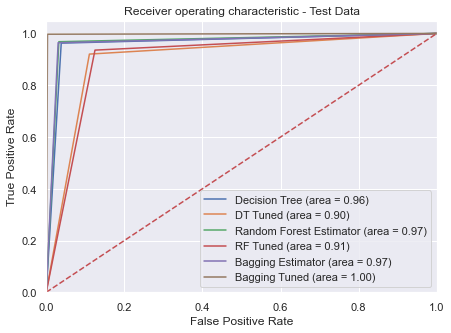

In [ ]:
plt.figure(figsize=(7, 5))

%time dTree_roc_auc_train = roc_auc_score(y_test, dTree.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test, dTree.predict(X_test))

plt.plot(fpr, tpr, label="Decision Tree (area = %0.2f)" % dTree_roc_auc_train)

%time dTreeTuned_roc_auc_train = roc_auc_score(y_test, dtree_tuned.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test, dtree_tuned.predict(X_test))

plt.plot(fpr, tpr, label="DT Tuned (area = %0.2f)" % dTreeTuned_roc_auc_train)

%time rf_roc_auc_train = roc_auc_score(y_test, rf_estimator.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test, rf_estimator.predict(X_test))

plt.plot(fpr, tpr, label="Random Forest Estimator (area = %0.2f)" % rf_roc_auc_train)

%time rfTuned_roc_auc_train = roc_auc_score(y_test, rf_estimator_tuned.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test, rf_estimator_tuned.predict(X_test))

plt.plot(fpr, tpr, label="RF Tuned (area = %0.2f)" % rfTuned_roc_auc_train)

%time bag_roc_auc_train = roc_auc_score(y_test, bagging_classifier.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test, bagging_classifier.predict(X_test))

plt.plot(fpr, tpr, label="Bagging Estimator (area = %0.2f)" % bag_roc_auc_train)

%time bagTuned_roc_auc_train = roc_auc_score(y_test, bagging_estimator_tuned.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test, bagging_estimator_tuned.predict(X_test))

plt.plot(fpr, tpr, label="Bagging Tuned (area = %0.2f)" % bagTuned_roc_auc_train)

plt.plot([0, 1], [0, 1], "r--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver operating characteristic - Test Data")
plt.legend(loc="lower right")
plt.show()



> **Absolute Difference between Training and Test Metrics Below**



In [ ]:
models_comp_df = round((models_test_comp_df - models_train_comp_df), 4)

print("Best Performing Models From Training to Test")
models_comp_df.style.highlight_max(color="lightgreen", axis=1)

Best Performing Models From Training to Test


,DTree,DTreeTuned,RF,RFTuned,Bag,BagTuned
Accuracy,-0.038000,-0.000200,-0.032200,0.001300,-0.030600,0.036700
Recall,-0.037400,-0.001500,-0.031900,0.000100,-0.032200,0.031300
Precision,-0.038900,0.000800,-0.032800,0.002100,-0.029500,0.042000
F1,-0.038200,-0.000300,-0.032400,0.001200,-0.030900,0.036700


In [ ]:
models_comp_df = round((models_test_comp_df - models_train_comp_df), 4)

print("Worse Performing Models From Training to Test")
models_comp_df.style.highlight_min(color="pink", axis=1)

Worse Performing Models From Training to Test


,DTree,DTreeTuned,RF,RFTuned,Bag,BagTuned
Accuracy,-0.038000,-0.000200,-0.032200,0.001300,-0.030600,0.036700
Recall,-0.037400,-0.001500,-0.031900,0.000100,-0.032200,0.031300
Precision,-0.038900,0.000800,-0.032800,0.002100,-0.029500,0.042000
F1,-0.038200,-0.000300,-0.032400,0.001200,-0.030900,0.036700


In [ ]:
models_comp_df = round(abs(models_test_comp_df - models_train_comp_df), 4)

print("Most Reliable Models: Smallest Change from Training to Test")
models_comp_df.style.highlight_min(color="yellow", axis=1)

Most Reliable Models: Smallest Change from Training to Test


,DTree,DTreeTuned,RF,RFTuned,Bag,BagTuned
Accuracy,0.038000,0.000200,0.032200,0.001300,0.030600,0.036700
Recall,0.037400,0.001500,0.031900,0.000100,0.032200,0.031300
Precision,0.038900,0.000800,0.032800,0.002100,0.029500,0.042000
F1,0.038200,0.000300,0.032400,0.001200,0.030900,0.036700




> **After tuning, it appears that although the Tuned Bagging Classifier had the best overall performance, the Tuned Decision Tree was the most consistent between the Training and Test data. Despite the lower performance, the Tuned Decision Tree would produce results consistant with the training data.**

